In [670]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import random 
import matplotlib as mpl
import sklearn 
import datetime
#!pip install xgboost
#!pip install hyperopt
###########for classification#################
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler #Used to scale data. also good idea when doing regularization
from sklearn import metrics
from  sklearn import linear_model, neural_network, ensemble
#!pip install category_encoders
import category_encoders as ce
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import hyperopt 
from hyperopt.pyll.stochastic import sample as ho_sample
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve 
##############################################
#set the pd output value
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
acc = pd.read_csv('Accidents0514.csv')
#cas = pd.read_csv('Casualties0514.csv')
#veh = pd.read_csv('Vehicles0514.csv')

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(acc.shape)
#print(cas.shape)
#print(veh.shape)

print(acc.Accident_Index.nunique())
#print(cas.Accident_Index.nunique())
#print(veh.Accident_Index.nunique())

(1640597, 32)
1640597


### Inspection of Accident Data set

In [4]:
acc.Accident_Index.nunique() #number of unique accidents

1640597

In [5]:
acc.Accident_Severity.value_counts() #count the number of accident severity

3    1397173
2     222042
1      21382
Name: Accident_Severity, dtype: int64

In [3]:
acc['fatal'] = np.where(acc['Accident_Severity'] == 1, 1,0) #create binary variable, if an accident was fatal

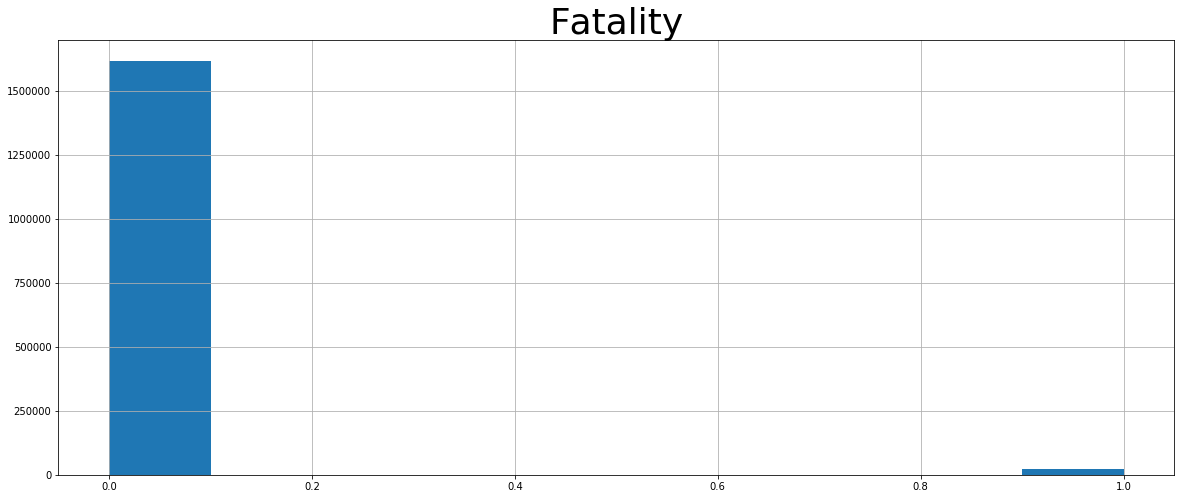

In [7]:
fig, ax1 = plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 30})
plt.title('Fatality')
acc.fatal.hist()

In [8]:
#1.3% of all accidents are deadly/fatal
acc.fatal.sum() / acc.fatal.count()

0.013033060526137742

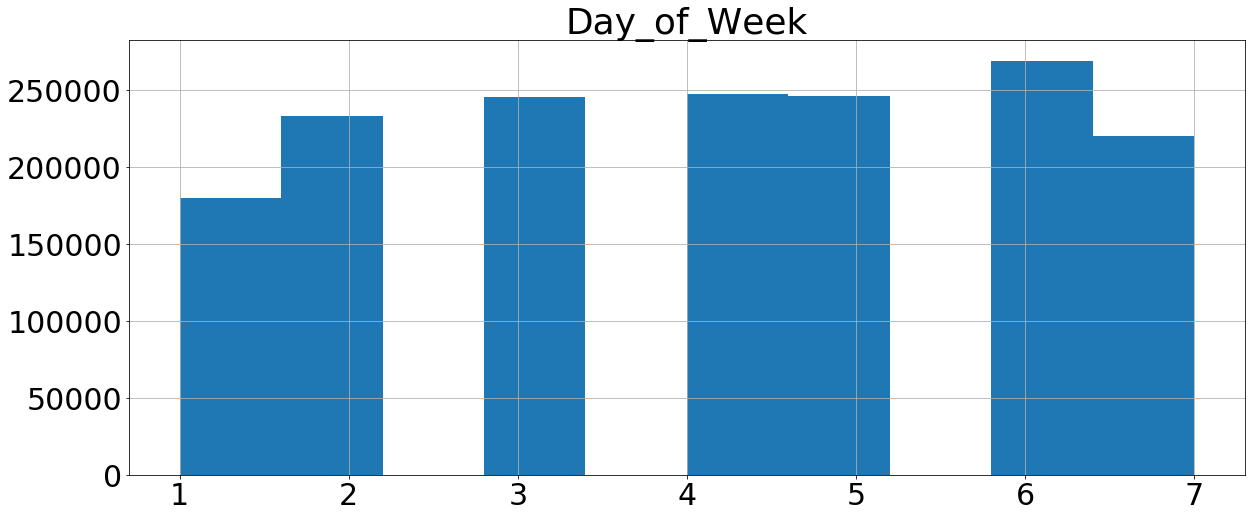

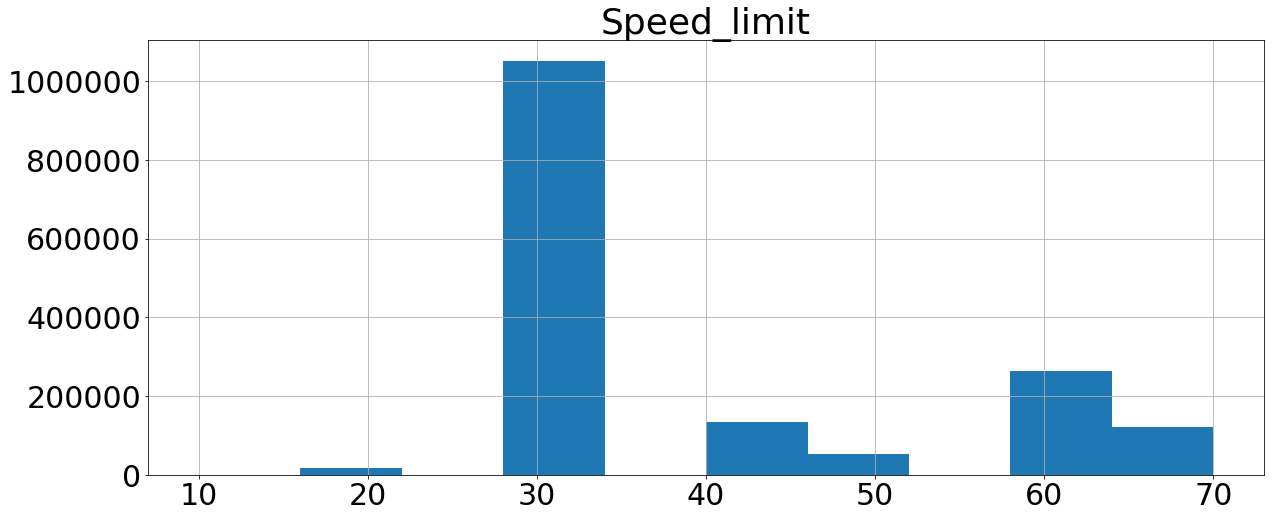

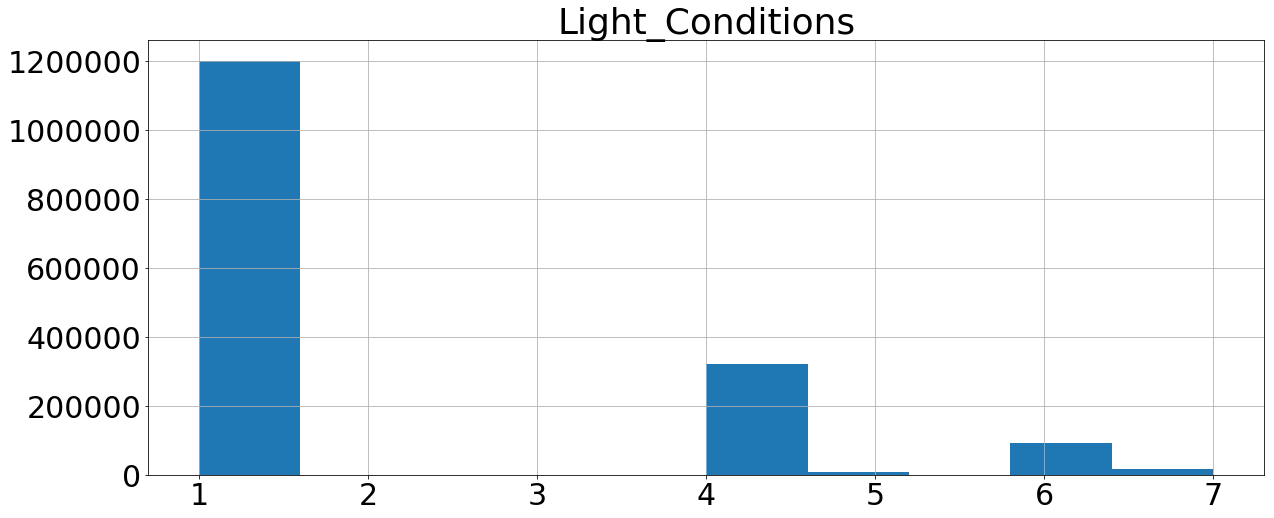

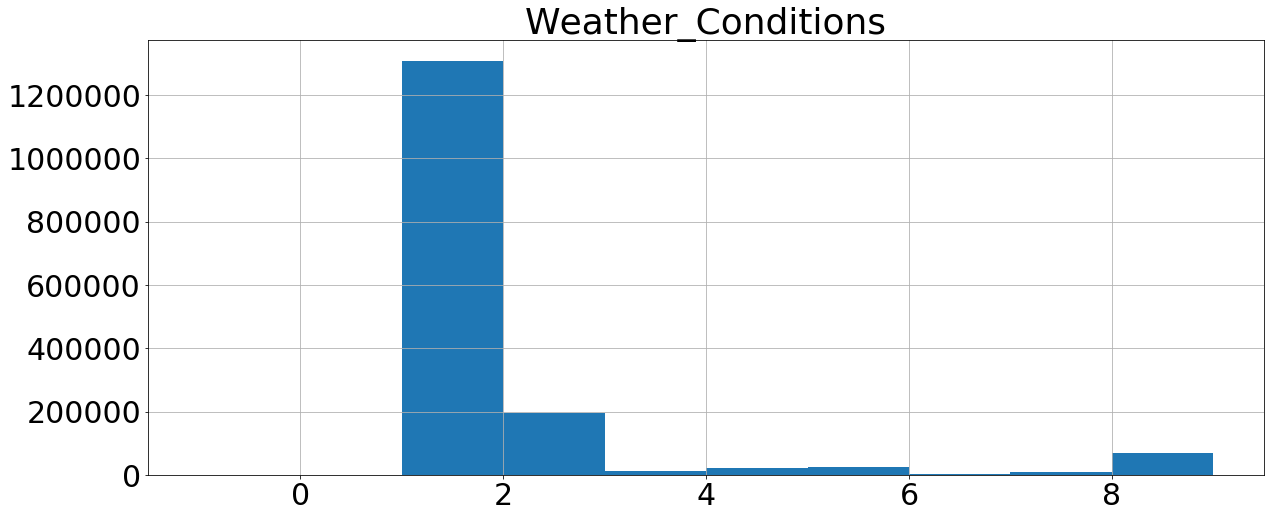

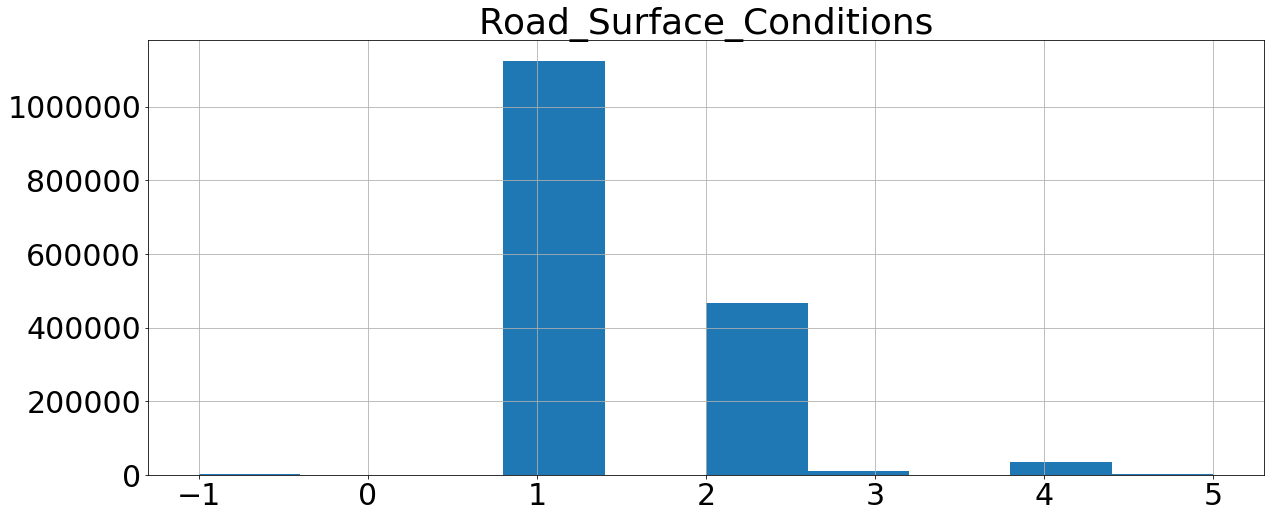

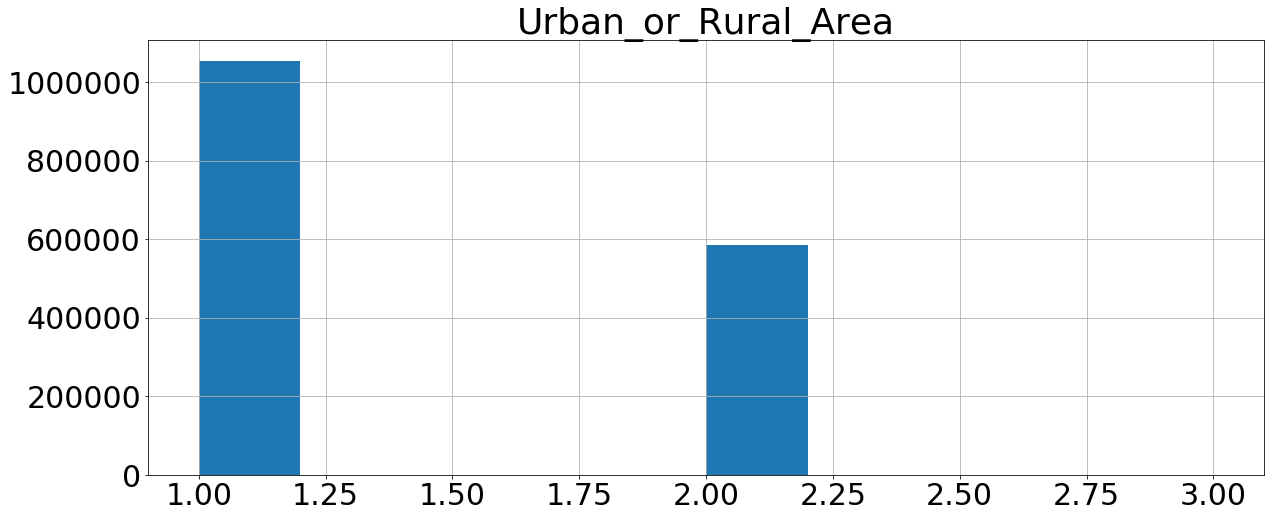

In [9]:
listx = ['Day_of_Week', 'Speed_limit', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area']

for i in listx:

    fig, ax1 = plt.subplots(figsize=(20,8))
    plt.rcParams.update({'font.size': 30})
    plt.title(i)
    acc[i].hist()

### Create categorical features

In [13]:
categorical = ['Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class',
               '1st_Road_Number', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number',
               'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
               'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Special_Conditions_at_Site', 
               'Carriageway_Hazards']

In [14]:
for col in categorical:
    acc[col] = acc[col].astype('category')

### Classification of fatal accidents

In [16]:
#Define Target and explanatory variables

target = ['fatal']

categorical = ['Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class',
               '1st_Road_Number', 'Road_Type', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number',
               'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
               'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area', 'Special_Conditions_at_Site', 
               'Carriageway_Hazards']

numerical = ['Speed_limit','Number_of_Vehicles','Number_of_Casualties']

#Specify test target 
target = acc[target] 

#features_cat = acc[categorical] # Keep all choose attributes
#features_num = acc[numerical] # Keep all choose attributes
list_features = categorical + numerical

features = acc[list_features] 

In [575]:
#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2, stratify = target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Check if fraction of positive class is similar in train and test
print(np.mean(y_test))
print(np.mean(y_train))

(1312477, 20)
(328120, 20)
(1312477, 1)
(328120, 1)
fatal    0.013032
dtype: float64
fatal    0.013033
dtype: float64


In [15]:
#We scale the data, to get better results. I will not test this, as normally we get better results using scaled data:
min_max_sc = MinMaxScaler()

### Use 3 base models to get predictions

In [566]:
#############Model 1: Logistic Regression##################
#Because we have unbalanced data, I already pick 'balanced' for class_weight in my base model. No need to test this. For sure
# it will give better results:
lr_basic = LogisticRegression(C = 1, random_state = 100, class_weight = 'balanced', solver = 'warn', max_iter = 100)
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', lr_basic)])
#scale_lr_pipeline.get_params()

In [567]:
#################Model 2: Random Forest Classification###################
dist_y = y_test.mean()
weights_rfc = dict({1 : dist_y[0]}) #method for random forest classifier
rfc_basic = RandomForestClassifier(class_weight = weights_rfc)
scale_rf_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', rfc_basic)])

In [582]:
#################Model 3: XG Boost############
#Get sample weight for unbalanced data: the ratio of number of negative class to the positive class
#weights_xg = y_train[y_train.fatal == 0].shape[0] / y_train[y_train.fatal == 1].shape[0] 
#Using 'scale_pos_weight' decreases the roc auc of the base model. This is why I decided to go without a balancing method here.
xgboost_basic = xgb.XGBClassifier()
scale_xg_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', xgboost_basic)])

In [576]:
#Encode categorical features
encoder = ce.CatBoostEncoder() 
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

In [583]:
#############################################################
#Run all three base models and get their initial performance:
scale_lr_pipeline.fit(X_train, y_train) #method for random forest classifier) #Logistic Regression
scale_rf_pipeline.fit(X_train, y_train) #Random Forest Classification
scale_xg_pipeline.fit(X_train, y_train) #XG Boost Classification

print(scale_lr_pipeline.score(X_train, y_train))
print(scale_rf_pipeline.score(X_train, y_train))
print(scale_xg_pipeline.score(X_train, y_train))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  retur

0.7278306591277409
0.9967306093744881
0.9870237726070629


In [584]:
#Get probabilities to display roc auc curve:
y_pred_proba_lr = scale_lr_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_lr = y_pred_proba_lr[:,1] #array of positive probability
neg_proba_lr = y_pred_proba_lr[:,0] #array of negative probability

y_pred_proba_rf = scale_rf_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_rf = y_pred_proba_rf[:,1] #array of positive probability
neg_proba_rf = y_pred_proba_rf[:,0] #array of negative probability

y_pred_proba_xg = scale_xg_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_xg = y_pred_proba_xg[:,1] #array of positive probability
neg_proba_xg = y_pred_proba_xg[:,0] #array of negative probability

#Get TPR and FPR and threshold values to plot curve:
fpr_basic, tpr_basic, threshold_lr = metrics.roc_curve(y_test, pos_proba_lr)
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, pos_proba_rf)
fpr_xg, tpr_xg, threshold_xg = metrics.roc_curve(y_test, pos_proba_xg)

In [585]:
#loop through tpr, fpr and threshold to get best threshold value to optimize the geometric mean:
thresholds = []
ids = []
lists = [(tpr_basic, fpr_basic, threshold_lr), (tpr_rf, fpr_rf, threshold_rf), (tpr_xg, fpr_xg, threshold_xg)]

for i,v in enumerate (lists):
    J = v[0] - v[1]
    ix = np.argmax(J)
    thresholds.append(v[2][ix])
    ids.append(ix)
    print('Best Threshold=%f' % (v[2][ix]))

Best Threshold=0.495608
Best Threshold=0.100000
Best Threshold=0.008473


In [586]:

#ROC AUC Score
print('Logistic regression:', roc_auc_score(y_test, pos_proba_lr))
print('Random Forest Classifier:', roc_auc_score(y_test, pos_proba_rf))
print('XG Boost:', roc_auc_score(y_test, pos_proba_xg))

Logistic regression: 0.7447418006953861
Random Forest Classifier: 0.6567725194956668
XG Boost: 0.7064076119917257


In [587]:
#Use the best threshold value to get classification report:
y_pred_lr = np.where(pos_proba_lr > thresholds[0], 1, 0)
y_pred_rf = np.where(pos_proba_rf > thresholds[1], 1, 0)
y_pred_xg = np.where(pos_proba_xg > thresholds[2], 1, 0)

#Return Classification Report:
print(classification_report(y_test, y_pred_lr, labels = [1]))
print()
print(classification_report(y_test, y_pred_rf, labels = [1]))
print()
print(classification_report(y_test, y_pred_xg, labels = [1]))

              precision    recall  f1-score   support

           1       0.03      0.68      0.06      4276

   micro avg       0.03      0.68      0.06      4276
   macro avg       0.03      0.68      0.06      4276
weighted avg       0.03      0.68      0.06      4276


              precision    recall  f1-score   support

           1       0.03      0.42      0.05      4276

   micro avg       0.03      0.42      0.05      4276
   macro avg       0.03      0.42      0.05      4276
weighted avg       0.03      0.42      0.05      4276


              precision    recall  f1-score   support

           1       0.02      0.63      0.05      4276

   micro avg       0.02      0.63      0.05      4276
   macro avg       0.02      0.63      0.05      4276
weighted avg       0.02      0.63      0.05      4276



Text(0.5, 1.0, 'ROC Curve')

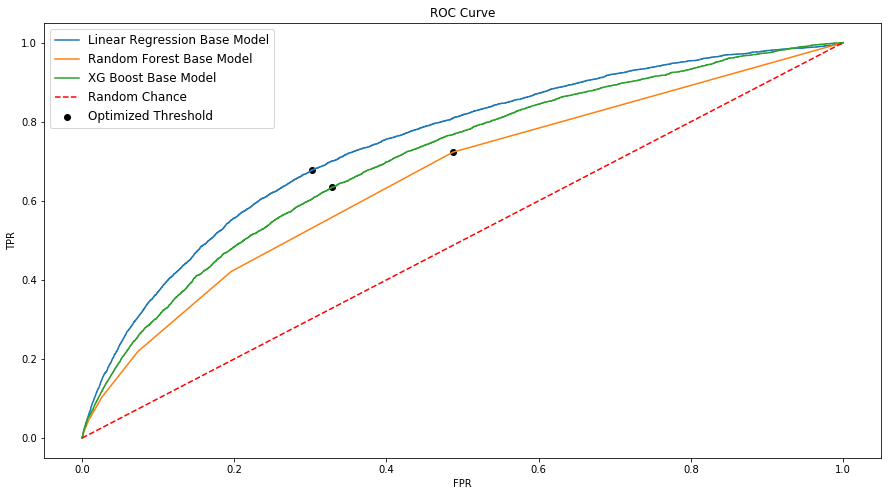

In [588]:
#Plot ROC AUC for the three base models:
plt.subplots(figsize=(15,8))

plt.plot(fpr_basic, tpr_basic, '')
plt.scatter(fpr_basic[ids[0]], tpr_basic[ids[0]], marker='o', color='black')

plt.plot(fpr_rf, tpr_rf, '')
plt.scatter(fpr_rf[ids[1]], tpr_rf[ids[1]], marker='o', color='black')

plt.plot(fpr_xg, tpr_xg, '')
plt.scatter(fpr_xg[ids[2]], tpr_xg[ids[2]], marker='o', color='black')

plt.plot([0,1],[0,1],'r--')
plt.legend(['Linear Regression Base Model','Random Forest Base Model','XG Boost Base Model', 'Random Chance', 'Optimized Threshold'], fontsize = 12)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

### Hyperparameter Tunning of the models

#### Logistic Regression

In [116]:
scale_lr_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'model', 'scaler__copy', 'scaler__feature_range', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

In [133]:
#determine whivh hparams will be used with intervals
space = { 'model__C': hp.quniform("model__C", 0.01, 30, 0.5),
        'model__max_iter' : hp.quniform('model__max_iter', 20, 750, 1),
        'model__solver' : hp.choice( 'model__solver',['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'warn']),
        'model__penalty' : hp.choice( 'model__penalty',['l1', 'l2', 'elasticnet']),
        'model__random_sate': 100,
        'model__n_jobs': -1,
        'model__class_weight' : 'balanced'}

In [134]:
def hyperparameter_tuning_lr(space):
    roc_auc_sc = 0
    loss = 1 
    try:
        #lr_basic = LogisticRegression
        min_max_sc = MinMaxScaler()
        reg = LogisticRegression(C = space['model__C'], 
                             max_iter = space['model__max_iter'], 
                             solver = space['model__solver'],
                             penalty = space['model__penalty'],
                             random_state = space['model__random_sate'],
                             n_jobs = space['model__n_jobs'],
                             class_weight = space['model__class_weight'])

        scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', reg)])
        scale_lr_pipeline.fit(X_train, y_train)
        
        y_pred_proba = scale_lr_pipeline.predict_proba(X_test) #returns the predicted probability 
        roc_auc_sc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
        loss = 1 - roc_auc_sc
        print ("ROC AUC SCORE:", loss)
    except:    
        pass    
    #change the metric if you like
    return {'loss': loss, 'status': STATUS_OK}

In [136]:
SEED = 10
#search for best hparams
trials = Trials()
now = datetime.datetime.today()
print('search started at ', now)
best = fmin(fn = hyperparameter_tuning_lr,
            space = space,
            algo = tpe.suggest,
            max_evals = 250,
            trials = trials,
            rstate = np.random.RandomState(SEED))

print(best)
print(space_eval(space, best))

search started at  2020-05-21 13:01:31.764800
  0%|                                                                          | 0/250 [00:00<?, ?trial/s, best loss=?]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550472857567415                                                                                                     
  0%|▏                                             | 1/250 [00:18<1:17:59, 18.79s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  1%|▍                                               | 2/250 [00:19<55:10, 13.35s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  1%|▌                                               | 3/250 [00:20<39:49,  9.67s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.35557852526645284                                                                                                    
  2%|▋                                             | 4/250 [04:18<5:20:35, 78.19s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  2%|▉                                             | 5/250 [04:19<3:44:11, 54.90s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2575328497504179                                                                                                     
  2%|█                                             | 6/250 [04:38<3:00:21, 44.35s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  3%|█▎                                            | 7/250 [04:39<2:06:24, 31.21s/trial, best loss: 0.2550472857567415]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25503762485555737                                                                                                    
  3%|█▍                                           | 8/250 [05:35<2:35:21, 38.52s/trial, best loss: 0.25503762485555737]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  4%|█▌                                           | 9/250 [05:35<1:48:58, 27.13s/trial, best loss: 0.25503762485555737]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502492370964414                                                                                                    
  4%|█▋                                        | 10/250 [15:25<13:04:19, 196.08s/trial, best loss: 0.25502492370964414]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  4%|█▉                                         | 11/250 [15:26<9:07:25, 137.43s/trial, best loss: 0.25502492370964414]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2757850846350405                                                                                                     
  5%|██                                         | 12/250 [18:10<9:36:24, 145.31s/trial, best loss: 0.25502492370964414]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2716433801829703                                                                                                     
  5%|██▏                                       | 13/250 [23:00<12:26:25, 188.97s/trial, best loss: 0.25502492370964414]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  6%|██▍                                        | 14/250 [23:01<8:40:56, 132.44s/trial, best loss: 0.25502492370964414]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502347291352523                                                                                                    
  6%|██▌                                       | 15/250 [32:47<17:31:44, 268.53s/trial, best loss: 0.25502347291352523]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2550142972960604                                                                                                     
  6%|██▊                                        | 16/250 [33:38<13:13:01, 203.34s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  7%|██▉                                         | 17/250 [33:39<9:13:25, 142.51s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25504543055752305                                                                                                    
  7%|███▏                                        | 18/250 [35:23<8:26:15, 130.93s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  8%|███▍                                         | 19/250 [35:23<5:53:29, 91.82s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  8%|███▌                                         | 20/250 [35:24<4:07:02, 64.44s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502348735649316                                                                                                    
  8%|███▌                                       | 21/250 [45:26<14:21:36, 225.75s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



  9%|███▊                                       | 22/250 [45:27<10:01:07, 158.19s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502347291352523                                                                                                    
  9%|███▉                                       | 23/250 [55:13<18:04:39, 286.69s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550519963307005                                                                                                     
 10%|████▏                                      | 24/250 [55:30<12:55:17, 205.83s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 10%|████▍                                       | 25/250 [55:31<9:00:55, 144.25s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502348446789946                                                                                                    
 10%|████▎                                    | 26/250 [1:05:16<17:12:43, 276.62s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550558879883832                                                                                                     
 11%|████▍                                    | 27/250 [1:05:33<12:18:37, 198.73s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234707470801                                                                                                     
 11%|████▌                                    | 28/250 [1:15:21<19:26:51, 315.37s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25505040688209024                                                                                                    
 12%|████▊                                    | 29/250 [1:16:54<15:15:58, 248.68s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25504286693073275                                                                                                    
 12%|████▉                                    | 30/250 [1:17:11<10:57:16, 179.26s/trial, best loss: 0.2550142972960604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25489352519903297                                                                                                    
 12%|████▉                                   | 31/250 [1:19:24<10:03:07, 165.24s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25504851629760095                                                                                                    
 13%|█████▏                                   | 32/250 [1:19:41<7:19:01, 120.83s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.2548992626680051                                                                                                     
 13%|█████▍                                   | 33/250 [1:21:55<7:31:40, 124.89s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502346496989303                                                                                                    
 14%|█████▍                                  | 34/250 [1:31:42<15:48:10, 263.38s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550235104652415                                                                                                     
 14%|█████▌                                  | 35/250 [1:41:30<21:33:23, 360.95s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.254900409439651                                                                                                      
 14%|█████▊                                  | 36/250 [1:43:44<17:24:26, 292.84s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502346858063485                                                                                                    
 15%|█████▉                                  | 37/250 [1:53:31<22:32:15, 380.92s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234960222738                                                                                                     
 15%|██████                                  | 38/250 [2:03:18<26:04:59, 442.92s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25498334384954713                                                                                                    
 16%|██████▏                                 | 39/250 [2:07:02<22:06:14, 377.13s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.27942947798642714                                                                                                    
 16%|██████▍                                 | 40/250 [2:10:25<18:57:29, 325.00s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502347291352523                                                                                                    
 16%|██████▌                                 | 41/250 [2:20:15<23:28:37, 404.39s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 17%|██████▋                                 | 42/250 [2:20:16<16:21:54, 283.24s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234960222738                                                                                                     
 17%|██████▉                                 | 43/250 [2:30:07<21:35:50, 375.60s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.26517334871728937                                                                                                    
 18%|███████                                 | 44/250 [2:43:57<29:17:46, 511.97s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 18%|███████▏                                | 45/250 [2:43:57<20:25:03, 358.55s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 18%|███████▎                                | 46/250 [2:43:58<14:13:55, 251.16s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 19%|███████▋                                 | 47/250 [2:43:59<9:55:24, 175.98s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 19%|███████▊                                 | 48/250 [2:43:59<6:55:17, 123.36s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2596042233675919                                                                                                     
 20%|████████                                 | 49/250 [2:47:10<8:01:28, 143.73s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 20%|████████▏                                | 50/250 [2:47:11<5:35:55, 100.78s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 20%|████████▌                                 | 51/250 [2:47:11<3:54:31, 70.71s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 21%|████████▋                                 | 52/250 [2:47:12<2:43:54, 49.67s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 21%|████████▉                                 | 53/250 [2:47:13<1:54:42, 34.94s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.26030790209202226                                                                                                    
 22%|████████▋                               | 54/250 [2:57:53<11:47:34, 216.60s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234656920414                                                                                                     
 22%|████████▊                               | 55/250 [3:07:42<17:46:35, 328.18s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25504952080601373                                                                                                    
 22%|████████▉                               | 56/250 [3:09:33<14:10:35, 263.07s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 23%|█████████▎                               | 57/250 [3:09:33<9:52:53, 184.32s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 23%|█████████▌                               | 58/250 [3:09:34<6:53:25, 129.19s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502344980477665                                                                                                    
 24%|█████████▍                              | 59/250 [3:19:19<14:06:41, 265.98s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2550641508102811                                                                                                     
 24%|█████████▌                              | 60/250 [3:20:48<11:14:15, 212.93s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502357040355816                                                                                                    
 24%|█████████▊                              | 61/250 [3:30:36<17:04:30, 325.24s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 25%|█████████▉                              | 62/250 [3:30:36<11:53:53, 227.84s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 25%|██████████▎                              | 63/250 [3:30:37<8:17:35, 159.65s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550358194845781                                                                                                     
 26%|██████████▍                              | 64/250 [3:30:54<6:02:27, 116.92s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550239372549411                                                                                                     
 26%|██████████▍                             | 65/250 [3:40:40<13:14:06, 257.55s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.2550109450832261                                                                                                     
 26%|██████████▌                             | 66/250 [3:45:47<13:55:18, 272.38s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25489646217654205                                                                                                    
 27%|██████████▋                             | 67/250 [3:47:59<11:42:39, 230.38s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550235386290288                                                                                                     
 27%|██████████▉                             | 68/250 [3:57:44<17:01:54, 336.89s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25502344619403483                                                                                                    
 28%|███████████                             | 69/250 [4:07:36<20:46:34, 413.23s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234750799705                                                                                                     
 28%|███████████▏                            | 70/250 [4:17:21<23:14:32, 464.85s/trial, best loss: 0.25489352519903297]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25489193791686804                                                                                                    
 28%|███████████▎                            | 71/250 [4:19:33<18:08:36, 364.90s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.2550110613491172                                                                                                     
 29%|███████████▌                            | 72/250 [4:24:39<17:10:33, 347.38s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 29%|███████████▋                            | 73/250 [4:24:40<11:57:49, 243.33s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502357040355816                                                                                                    
 30%|███████████▊                            | 74/250 [4:34:25<16:54:53, 345.99s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 30%|████████████                            | 75/250 [4:34:26<11:46:52, 242.36s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25504286693073275                                                                                                    
 30%|████████████▍                            | 76/250 [4:34:43<8:27:06, 174.87s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235393511773                                                                                                     
 31%|████████████▎                           | 77/250 [4:44:29<14:20:06, 298.31s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502366572714585                                                                                                    
 31%|████████████▍                           | 78/250 [4:54:16<18:23:04, 384.79s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 32%|████████████▋                           | 79/250 [4:54:17<12:48:08, 269.52s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 32%|█████████████                            | 80/250 [4:54:17<8:55:02, 188.84s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502408673965826                                                                                                    
 32%|████████████▉                           | 81/250 [5:04:03<14:27:21, 307.94s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2551077461865394                                                                                                     
 33%|█████████████                           | 82/250 [5:05:00<10:51:17, 232.60s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.2550208385161923                                                                                                     
 33%|█████████████▎                          | 83/250 [5:11:36<13:03:50, 281.62s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234750799705                                                                                                     
 34%|█████████████▍                          | 84/250 [5:21:22<17:11:32, 372.84s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 34%|█████████████▌                          | 85/250 [5:21:22<11:58:11, 261.16s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550237372198366                                                                                                     
 34%|█████████████▊                          | 86/250 [5:31:10<16:21:42, 359.16s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502348735649316                                                                                                    
 35%|█████████████▉                          | 87/250 [5:41:19<19:39:18, 434.10s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2859598687811311                                                                                                     
 35%|██████████████                          | 88/250 [5:46:39<17:59:55, 399.97s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 36%|██████████████▏                         | 89/250 [5:46:40<12:31:45, 280.16s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 36%|██████████████▊                          | 90/250 [5:46:40<8:43:25, 196.28s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 36%|██████████████▉                          | 91/250 [5:46:41<6:04:33, 137.57s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 37%|███████████████▍                          | 92/250 [5:46:42<4:14:02, 96.47s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550235393511773                                                                                                     
 37%|██████████████▉                         | 93/250 [5:57:10<11:09:49, 255.98s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25503682977017794                                                                                                    
 38%|███████████████▍                         | 94/250 [5:57:29<8:00:52, 184.95s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502357040355816                                                                                                    
 38%|███████████████▏                        | 95/250 [6:08:28<14:05:17, 327.21s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 38%|███████████████▋                         | 96/250 [6:08:29<9:48:20, 229.22s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.26201059476326405                                                                                                    
 39%|███████████████▉                         | 97/250 [6:09:30<7:35:58, 178.81s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 39%|████████████████                         | 98/250 [6:09:30<5:17:32, 125.34s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.2549857659352528                                                                                                     
 40%|████████████████▏                        | 99/250 [6:13:23<6:36:39, 157.61s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2550916913834952                                                                                                     
 40%|████████████████                        | 100/250 [6:15:37<6:15:59, 150.40s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234895229383                                                                                                     
 40%|███████████████▊                       | 101/250 [6:25:22<11:37:12, 280.76s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 41%|████████████████▎                       | 102/250 [6:25:22<8:05:11, 196.70s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2548964693980259                                                                                                     
 41%|████████████████▍                       | 103/250 [6:27:35<7:14:41, 177.42s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502349818871894                                                                                                    
 42%|████████████████▏                      | 104/250 [6:37:21<12:10:21, 300.15s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550235068544996                                                                                                     
 42%|████████████████▍                      | 105/250 [6:47:07<15:32:10, 385.72s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2641456600632146                                                                                                     
 42%|████████████████▌                      | 106/250 [6:55:04<16:31:19, 413.05s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 43%|████████████████▋                      | 107/250 [6:55:04<11:29:30, 289.30s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 43%|█████████████████▎                      | 108/250 [6:55:05<7:59:40, 202.68s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 44%|█████████████████▍                      | 109/250 [6:55:05<5:33:48, 142.05s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502351985317084                                                                                                    
 44%|█████████████████▏                     | 110/250 [7:04:51<10:42:09, 275.21s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 44%|█████████████████▊                      | 111/250 [7:04:52<7:26:41, 192.82s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25503370286764204                                                                                                    
 45%|█████████████████▉                      | 112/250 [7:05:09<5:22:24, 140.18s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502346496989303                                                                                                    
 45%|█████████████████▋                     | 113/250 [7:14:55<10:25:18, 273.86s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 46%|██████████████████▏                     | 114/250 [7:14:56<7:14:55, 191.88s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.26559421030063457                                                                                                    
 46%|██████████████████▍                     | 115/250 [7:16:47<6:17:22, 167.72s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 46%|██████████████████▌                     | 116/250 [7:16:47<4:22:34, 117.57s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25498646930778635                                                                                                    
 47%|██████████████████▋                     | 117/250 [7:20:34<5:32:52, 150.17s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2552983716974955                                                                                                     
 47%|██████████████████▉                     | 118/250 [7:21:29<4:27:57, 121.80s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234895229383                                                                                                     
 48%|███████████████████                     | 119/250 [7:31:16<9:30:10, 261.15s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 48%|███████████████████▏                    | 120/250 [7:31:16<6:36:26, 182.97s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502346858063485                                                                                                    
 48%|██████████████████▉                    | 121/250 [7:41:01<10:52:35, 303.53s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.255023481579306                                                                                                      
 49%|███████████████████                    | 122/250 [7:50:48<13:48:54, 388.55s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502348735649316                                                                                                    
 49%|███████████████████▏                   | 123/250 [8:00:33<15:47:18, 447.54s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2603501976011756                                                                                                     
 50%|███████████████████▎                   | 124/250 [8:07:39<15:26:30, 441.19s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 50%|███████████████████▌                   | 125/250 [8:07:40<10:43:45, 309.00s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 50%|████████████████████▏                   | 126/250 [8:07:41<7:27:22, 216.47s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 51%|████████████████████▎                   | 127/250 [8:07:41<5:10:59, 151.71s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550235386290288                                                                                                     
 51%|████████████████████▍                   | 128/250 [8:17:57<9:51:40, 290.99s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 52%|████████████████████▋                   | 129/250 [8:17:58<6:51:07, 203.86s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550461555945084                                                                                                     
 52%|████████████████████▊                   | 130/250 [8:18:15<4:56:04, 148.04s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502348735649316                                                                                                    
 52%|████████████████████▉                   | 131/250 [8:28:00<9:13:35, 279.12s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 53%|█████████████████████                   | 132/250 [8:28:01<6:24:35, 195.56s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2668081879645733                                                                                                     
 53%|█████████████████████▎                  | 133/250 [8:30:26<5:51:52, 180.45s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 54%|█████████████████████▍                  | 134/250 [8:30:27<4:04:32, 126.48s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234266960282                                                                                                     
 54%|█████████████████████▌                  | 135/250 [8:40:12<8:26:20, 264.18s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550447069648346                                                                                                     
 54%|█████████████████████▊                  | 136/250 [8:40:30<6:01:16, 190.14s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 55%|█████████████████████▉                  | 137/250 [8:40:30<4:11:00, 133.27s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 55%|██████████████████████▋                  | 138/250 [8:40:31<2:54:27, 93.46s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234786907124                                                                                                     
 56%|██████████████████████▏                 | 139/250 [8:50:21<7:28:32, 242.46s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550235068544996                                                                                                     
 56%|█████████████████████▊                 | 140/250 [9:00:08<10:34:18, 345.99s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502347291352534                                                                                                    
 56%|█████████████████████▉                 | 141/250 [9:09:55<12:39:48, 418.25s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.25781650530578604                                                                                                    
 57%|██████████████████████▏                | 142/250 [9:12:36<10:13:59, 341.11s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 57%|██████████████████████▉                 | 143/250 [9:12:37<7:06:06, 238.94s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502344980477665                                                                                                    
 58%|██████████████████████▍                | 144/250 [9:22:23<10:05:55, 342.97s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 58%|███████████████████████▏                | 145/250 [9:22:23<7:00:26, 240.25s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.254891945138352                                                                                                      
 58%|███████████████████████▎                | 146/250 [9:24:35<6:00:07, 207.77s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502344980477665                                                                                                    
 59%|███████████████████████▌                | 147/250 [9:34:22<9:11:46, 321.42s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2548920874015851                                                                                                     
 59%|███████████████████████▋                | 148/250 [9:36:34<7:29:40, 264.52s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2548939454893969                                                                                                     
 60%|███████████████████████▊                | 149/250 [9:38:45<6:18:05, 224.61s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25501264429839166                                                                                                    
 60%|████████████████████████                | 150/250 [9:44:03<7:00:55, 252.56s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550239372549411                                                                                                     
 60%|████████████████████████▏               | 151/250 [9:54:02<9:48:02, 356.39s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234656920414                                                                                                     
 61%|███████████████████████               | 152/250 [10:03:47<11:34:22, 425.13s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502349818871894                                                                                                    
 61%|███████████████████████▎              | 153/250 [10:13:34<12:45:38, 473.60s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550216682646944                                                                                                     
 62%|███████████████████████▍              | 154/250 [10:20:34<12:12:11, 457.62s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502366572714585                                                                                                    
 62%|███████████████████████▌              | 155/250 [10:30:20<13:05:30, 496.11s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25498669317378775                                                                                                    
 62%|███████████████████████▋              | 156/250 [10:34:08<10:51:03, 415.57s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502357040355816                                                                                                    
 63%|███████████████████████▊              | 157/250 [10:43:53<12:03:18, 466.65s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234707470801                                                                                                     
 63%|████████████████████████              | 158/250 [10:53:40<12:50:35, 502.56s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2548937086247246                                                                                                     
 64%|████████████████████████▊              | 159/250 [10:55:51<9:53:19, 391.20s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550237025567138                                                                                                     
 64%|████████████████████████▎             | 160/250 [11:05:40<11:15:34, 450.39s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25498916219913903                                                                                                    
 64%|█████████████████████████              | 161/250 [11:09:33<9:31:23, 385.21s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502152816790646                                                                                                    
 65%|█████████████████████████▎             | 162/250 [11:16:34<9:40:37, 395.88s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502396758517365                                                                                                    
 65%|████████████████████████▊             | 163/250 [11:26:19<10:56:21, 452.66s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25503919263971564                                                                                                    
 66%|█████████████████████████▌             | 164/250 [11:26:36<7:41:36, 322.06s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235386290288                                                                                                     
 66%|█████████████████████████▋             | 165/250 [11:36:22<9:28:34, 401.34s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 66%|█████████████████████████▉             | 166/250 [11:36:23<6:33:33, 281.11s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 67%|██████████████████████████             | 167/250 [11:36:24<4:32:27, 196.95s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550236036223842                                                                                                     
 67%|██████████████████████████▏            | 168/250 [11:46:10<7:09:03, 313.95s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.31187975107926236                                                                                                    
 68%|██████████████████████████▎            | 169/250 [11:48:49<6:00:40, 267.17s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.44348950814865884                                                                                                    
 68%|██████████████████████████▌            | 170/250 [11:51:56<5:24:13, 243.17s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502109632316816                                                                                                    
 68%|██████████████████████████▋            | 171/250 [11:58:45<6:25:47, 293.01s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 69%|██████████████████████████▊            | 172/250 [11:58:46<4:26:51, 205.28s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 69%|██████████████████████████▉            | 173/250 [11:58:46<3:04:37, 143.86s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234895229383                                                                                                     
 70%|███████████████████████████▏           | 174/250 [12:08:33<5:50:31, 276.73s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502357040355816                                                                                                    
 70%|███████████████████████████▎           | 175/250 [12:18:19<7:41:48, 369.45s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.27518989354134626                                                                                                    
 70%|███████████████████████████▍           | 176/250 [12:20:02<5:57:18, 289.71s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.27186202360722733                                                                                                    
 71%|███████████████████████████▌           | 177/250 [12:20:36<4:19:06, 212.97s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2548934017116581                                                                                                     
 71%|███████████████████████████▊           | 178/250 [12:22:47<3:46:03, 188.38s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502351696457704                                                                                                    
 72%|███████████████████████████▉           | 179/250 [12:32:33<6:04:02, 307.64s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 72%|████████████████████████████           | 180/250 [12:32:34<4:11:26, 215.52s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

ROC AUC SCORE:                                                                                                         
0.2550131664116789                                                                                                     
 72%|████████████████████████████▏          | 181/250 [12:37:53<4:43:45, 246.75s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234844678996                                                                                                     
 73%|████████████████████████████▍          | 182/250 [12:47:40<6:35:09, 348.67s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235104652415                                                                                                     
 73%|████████████████████████████▌          | 183/250 [12:57:25<7:48:31, 419.58s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25503370286764204                                                                                                    
 74%|████████████████████████████▋          | 184/250 [12:57:42<5:28:48, 298.92s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

 74%|████████████████████████████▊          | 185/250 [12:57:43<3:47:05, 209.62s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502348230145433                                                                                                    
 74%|█████████████████████████████          | 186/250 [13:07:29<5:43:53, 322.40s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 75%|█████████████████████████████▏         | 187/250 [13:07:30<3:57:08, 225.85s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_

ROC AUC SCORE:                                                                                                         
0.25502348735649305                                                                                                    
 75%|█████████████████████████████▎         | 188/250 [13:17:14<5:44:40, 333.55s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 76%|█████████████████████████████▍         | 189/250 [13:17:15<3:57:33, 233.66s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235082987964                                                                                                     
 76%|█████████████████████████████▋         | 190/250 [13:27:01<5:39:26, 339.44s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2550433984319489                                                                                                     
 76%|█████████████████████████████▊         | 191/250 [13:27:57<4:09:57, 254.19s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502348446789946                                                                                                    
 77%|█████████████████████████████▉         | 192/250 [13:37:41<5:41:36, 353.39s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.2658720890299432                                                                                                     
 77%|██████████████████████████████         | 193/250 [13:43:10<5:28:42, 346.02s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 78%|██████████████████████████████▎        | 194/250 [13:43:11<3:46:13, 242.38s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502347291352534                                                                                                    
 78%|██████████████████████████████▍        | 195/250 [13:52:56<5:16:31, 345.30s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234786907124                                                                                                     
 78%|██████████████████████████████▌        | 196/250 [14:02:41<6:15:33, 417.28s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 79%|██████████████████████████████▋        | 197/250 [14:02:42<4:18:10, 292.27s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2550367084492483                                                                                                     
 79%|██████████████████████████████▉        | 198/250 [14:03:32<3:10:23, 219.68s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234750799705                                                                                                     
 80%|███████████████████████████████        | 199/250 [14:13:18<4:39:56, 329.34s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550244535910412                                                                                                     
 80%|███████████████████████████████▏       | 200/250 [14:23:04<5:38:40, 406.40s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 80%|███████████████████████████████▎       | 201/250 [14:23:04<3:52:27, 284.65s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550256964084233                                                                                                     
 81%|███████████████████████████████▌       | 202/250 [14:32:50<4:59:55, 374.90s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 81%|███████████████████████████████▋       | 203/250 [14:32:50<3:25:42, 262.61s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 82%|███████████████████████████████▊       | 204/250 [14:32:51<2:21:03, 184.00s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25501293171345163                                                                                                    
 82%|███████████████████████████████▉       | 205/250 [14:38:10<2:48:17, 224.38s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25504645384179414                                                                                                    
 82%|████████████████████████████████▏      | 206/250 [14:39:04<2:07:02, 173.23s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502346496989303                                                                                                    
 83%|████████████████████████████████▎      | 207/250 [14:48:48<3:32:36, 296.66s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 83%|████████████████████████████████▍      | 208/250 [14:48:49<2:25:29, 207.84s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge

ROC AUC SCORE:                                                                                                         
0.2795805117118083                                                                                                     
 84%|████████████████████████████████▌      | 209/250 [14:49:56<1:53:06, 165.53s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 84%|████████████████████████████████▊      | 210/250 [14:49:56<1:17:21, 116.04s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502347291352534                                                                                                    
 84%|████████████████████████████████▉      | 211/250 [14:59:41<2:46:52, 256.74s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 85%|█████████████████████████████████      | 212/250 [14:59:42<1:53:55, 179.89s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.255043688013454                                                                                                      
 85%|█████████████████████████████████▏     | 213/250 [14:59:59<1:20:52, 131.14s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235386290288                                                                                                     
 86%|█████████████████████████████████▍     | 214/250 [15:09:46<2:40:43, 267.88s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 86%|█████████████████████████████████▌     | 215/250 [15:09:47<1:49:29, 187.69s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235068544996                                                                                                     
 86%|█████████████████████████████████▋     | 216/250 [15:19:32<2:53:54, 306.91s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.6110207034282256                                                                                                     
 87%|█████████████████████████████████▊     | 217/250 [15:21:57<2:22:09, 258.46s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 87%|██████████████████████████████████     | 218/250 [15:21:58<1:36:34, 181.09s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502366572714585                                                                                                    
 88%|██████████████████████████████████▏    | 219/250 [15:31:44<2:36:17, 302.52s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25522360623020635                                                                                                    
 88%|██████████████████████████████████▎    | 220/250 [15:32:09<1:49:44, 219.48s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25489846541618066                                                                                                    
 88%|██████████████████████████████████▍    | 221/250 [15:34:22<1:33:32, 193.52s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 89%|██████████████████████████████████▋    | 222/250 [15:34:23<1:03:17, 135.64s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502351985317084                                                                                                    
 89%|██████████████████████████████████▊    | 223/250 [15:44:09<2:01:54, 270.90s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234786907124                                                                                                     
 90%|██████████████████████████████████▉    | 224/250 [15:53:55<2:38:15, 365.21s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 90%|███████████████████████████████████    | 225/250 [15:53:55<1:46:35, 255.83s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.26566843993381706                                                                                                    
 90%|███████████████████████████████████▎   | 226/250 [15:56:30<1:30:13, 225.57s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25503850226585323                                                                                                    
 91%|███████████████████████████████████▍   | 227/250 [15:56:48<1:02:31, 163.11s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502346496989303                                                                                                    
 91%|███████████████████████████████████▌   | 228/250 [16:06:38<1:46:50, 291.40s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 92%|███████████████████████████████████▋   | 229/250 [16:06:39<1:11:27, 204.16s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 92%|█████████████████████████████████████▋   | 230/250 [16:06:39<47:41, 143.08s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 92%|█████████████████████████████████████▉   | 231/250 [16:06:40<31:46, 100.33s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25498724850590093                                                                                                    
 93%|██████████████████████████████████████   | 232/250 [16:10:30<41:44, 139.12s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.25502348735649305                                                                                                    
 93%|██████████████████████████████████▍  | 233/250 [20:30:45<22:34:55, 4782.08s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550461555945084                                                                                                     
 94%|██████████████████████████████████▋  | 234/250 [20:31:03<14:54:06, 3352.90s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.297831482114597                                                                                                      
 94%|██████████████████████████████████▊  | 235/250 [20:38:23<10:19:43, 2478.90s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 94%|███████████████████████████████████▊  | 236/250 [20:38:24<6:44:55, 1735.40s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25489641234830296                                                                                                    
 95%|████████████████████████████████████  | 237/250 [20:40:39<4:32:01, 1255.50s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))



ROC AUC SCORE:                                                                                                         
0.2550234707470801                                                                                                     
 95%|████████████████████████████████████▏ | 238/250 [20:50:26<3:30:56, 1054.75s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25502357040355816                                                                                                    
 96%|█████████████████████████████████████▎ | 239/250 [21:00:15<2:47:45, 915.07s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 96%|█████████████████████████████████████▍ | 240/250 [21:00:15<1:46:47, 640.72s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25503762485555737                                                                                                    
 96%|█████████████████████████████████████▌ | 241/250 [21:01:12<1:09:49, 465.50s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25501341266428057                                                                                                    
 97%|███████████████████████████████████████▋ | 242/250 [21:06:35<56:22, 422.75s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 97%|███████████████████████████████████████▊ | 243/250 [21:06:36<34:32, 296.10s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550235386290288                                                                                                     
 98%|████████████████████████████████████████ | 244/250 [21:16:22<38:19, 383.18s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



ROC AUC SCORE:                                                                                                         
0.5079804907625725                                                                                                     
 98%|████████████████████████████████████████▏| 245/250 [21:18:11<25:04, 300.82s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



 98%|████████████████████████████████████████▎| 246/250 [21:18:11<14:02, 210.75s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "t

ROC AUC SCORE:                                                                                                         
0.25498805803424807                                                                                                    
 99%|████████████████████████████████████████▌| 247/250 [21:22:01<10:49, 216.43s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.25503896083008204                                                                                                    
 99%|████████████████████████████████████████▋| 248/250 [21:22:18<05:13, 156.72s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
 

ROC AUC SCORE:                                                                                                         
0.2550234656920414                                                                                                     
100%|████████████████████████████████████████▊| 249/250 [21:32:44<04:57, 297.35s/trial, best loss: 0.25489193791686804]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



100%|█████████████████████████████████████████| 250/250 [21:32:44<00:00, 310.26s/trial, best loss: 0.25489193791686804]
{'model__C': 12.5, 'model__max_iter': 21.0, 'model__penalty': 0, 'model__solver': 2}
{'model__C': 12.5, 'model__class_weight': 'balanced', 'model__max_iter': 21.0, 'model__n_jobs': -1, 'model__penalty': 'l1', 'model__random_sate': 100, 'model__solver': 'liblinear'}


In [274]:
#Using class_weight = balanced boosts the accuracy of the model!
lr_grid = LogisticRegression(C = 12.5, random_state = 100, class_weight = 'balanced', solver = 'liblinear', penalty = 'l1', max_iter = 21, n_jobs = -1)
scale_lrgrid_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', lr_grid)])

scale_lrgrid_pipeline.fit(X_train, y_train) 

y_pred_lrgrid = scale_lrgrid_pipeline.predict(X_test) #predict y using pipeline
y_pred_proba_lrgrid = scale_lrgrid_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_lrgrid = y_pred_proba_lrgrid[:,1] #array of positive probability
neg_proba_lrgrid = y_pred_proba_lrgrid[:,0] #array of negative probability

#ROC AUC Score
print(roc_auc_score(y_test, pos_proba_lrgrid))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the 

0.745108062083132


In [647]:
#Get TPR and FPR and threshold values to plot curve:
fpr_lrgrid, tpr_lrgrid, threshold_lrgrid = metrics.roc_curve(y_test, pos_proba_lrgrid, drop_intermediate = False)

# get the best threshold using the Youden`s J statistic:
J = tpr_lrgrid - fpr_lrgrid
ix_lr_opti = np.argmax(J)
best_thresh = threshold_lrgrid[ix_lr_opti]
print('Best Threshold=%f' % (best_thresh))

y_pred_lr_grid = np.where(pos_proba_lrgrid > best_thresh, 1, 0)

TP_new = metrics.confusion_matrix(y_test, y_pred_lr_grid)[1][1] / (metrics.confusion_matrix(y_test, y_pred_lr_grid)[1][1] + metrics.confusion_matrix(y_test, y_pred_lr_grid)[1][0])
FP_new = metrics.confusion_matrix(y_test, y_pred_lr_grid)[0][1] / (metrics.confusion_matrix(y_test, y_pred_lr_grid)[0][0] + metrics.confusion_matrix(y_test, y_pred_lr_grid)[0][1])
TN_new = metrics.confusion_matrix(y_test, y_pred_lr_grid)[0][0] / (metrics.confusion_matrix(y_test, y_pred_lr_grid)[0][0] + metrics.confusion_matrix(y_test, y_pred_lr_grid)[0][1])
FN_new = metrics.confusion_matrix(y_test, y_pred_lr_grid)[1][0] / (metrics.confusion_matrix(y_test, y_pred_lr_grid)[1][1] + metrics.confusion_matrix(y_test, y_pred_lr_grid)[1][0])

print('TP Rate:', TP_new)
print('FN Rate:', FN_new)
print('FP Rate:', FP_new)
print('TN Rate:', TN_new)

Best Threshold=0.502528
TP Rate: 0.6655753040224509
FN Rate: 0.3344246959775491
FP Rate: 0.29028482849767173
TN Rate: 0.7097151715023283


In [392]:
#Return Classification Report:
print(classification_report(y_test, y_pred_lr, labels=[1]))
print(classification_report(y_test, y_pred_lrgrid, labels=[1]))

              precision    recall  f1-score   support

           1       0.03      0.67      0.06      4276

   micro avg       0.03      0.67      0.06      4276
   macro avg       0.03      0.67      0.06      4276
weighted avg       0.03      0.67      0.06      4276

              precision    recall  f1-score   support

           1       0.03      0.67      0.06      4276

   micro avg       0.03      0.67      0.06      4276
   macro avg       0.03      0.67      0.06      4276
weighted avg       0.03      0.67      0.06      4276



In [393]:
#Improvement in ROC AUC from base model after tunning:
print('Due to the running we improved the Logistic Regression by {} percent'.format(roc_auc_score(y_test, pos_proba_lrgrid) / roc_auc_score(y_test, pos_proba_lr) - 1))

Due to the running we improved the Logistic Regression by 0.0004917964687947141 percent


Text(0.5, 1.0, 'ROC Curce')

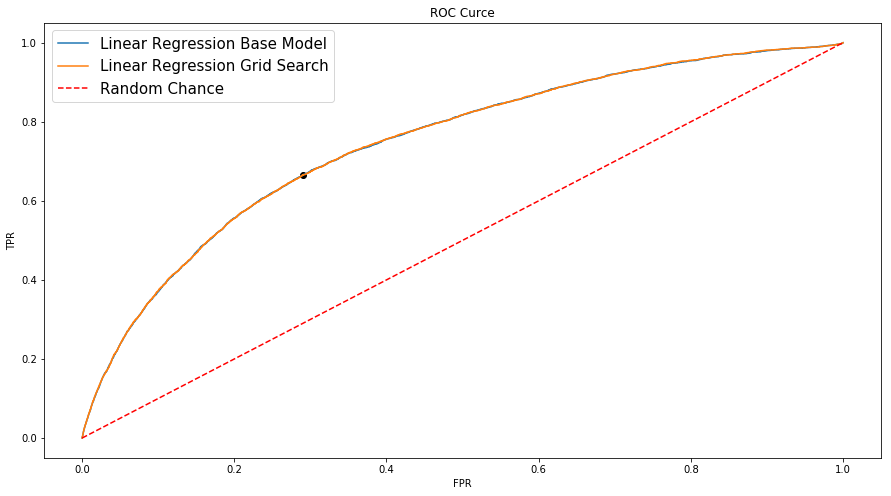

In [394]:
#Compare ROC AUC of basic model and grid search
#Get TPR and FPR and threshold values to plot curve:
fpr_lrgrid, tpr_lrgrid, threshold_lrgrid = metrics.roc_curve(y_test, pos_proba_lrgrid, drop_intermediate = False)

plt.subplots(figsize=(15,8))

plt.plot(fpr_basic, tpr_basic, '')
plt.plot(fpr_lrgrid, tpr_lrgrid, '')
plt.scatter(fpr_lrgrid[ix], tpr_lrgrid[ix], marker='o', color='black')
plt.plot([0,1],[0,1],'r--')
plt.legend(['Linear Regression Base Model','Linear Regression Grid Search', 'Random Chance'], fontsize = 15)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curce')

#### Random Forest Classifier

In [157]:
scale_rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'model', 'scaler__copy', 'scaler__feature_range', 'model__bootstrap', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

In [195]:
#determine whivh hparams will be used with intervals
class_weight = dict({1 : 0.013})
space_rfc = {'model__n_estimators': 'warn',
        'model__max_features' : hp.choice('model__max_features', ['auto', 'sqrt']),
        'model__min_samples_leaf' : hp.quniform( 'model__min_samples_leaf', 1, 25, 1),
        'model__min_samples_split' : hp.quniform('model__min_samples_split', 2, 25, 1),
        'model__oob_score': hp.choice('model__oob_score', [True, False]),
        'model__random_sate': 100,
        'model__n_jobs': -1,
        'model__class_weight' : class_weight}

In [209]:
def hyperparameter_tuning_rfc(space_rfc):
    roc_auc_sc = 0
    loss = 1 
    try:
        min_max_sc = MinMaxScaler()
        reg = RandomForestClassifier(n_estimators = space_rfc['model__n_estimators'], 
                             max_features = space_rfc['model__max_features'], 
                             min_samples_leaf = int(space_rfc['model__min_samples_leaf']),
                             min_samples_split = int(space_rfc['model__min_samples_split']),
                             oob_score = space_rfc['model__oob_score'],        
                             random_state = space_rfc['model__random_sate'],
                             n_jobs = space_rfc['model__n_jobs'],
                             class_weight = space_rfc['model__class_weight'])

        scale_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', reg)])
        scale_pipeline.fit(X_train, y_train)
        
        y_pred_proba = scale_pipeline.predict_proba(X_test) #returns the predicted probability 
        roc_auc_sc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
        loss = 1 - roc_auc_sc
        print ("ROC AUC SCORE:", loss)
    except:    
        pass    
    #change the metric if you like
    return {'loss': loss, 'status': STATUS_OK}

In [198]:
SEED = 10
#search for best hparams
trials = Trials()
now = datetime.datetime.today()
print('search started at ', now)
best = fmin(fn = hyperparameter_tuning_rfc,
            space = space_rfc,
            algo = tpe.suggest,
            max_evals = 100,
            trials = trials,
            rstate = np.random.RandomState(SEED))

print(best)
print(space_eval(space_rfc, best))

search started at  2020-05-22 16:16:55.895382
  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2936108695909887                                                                                                     
  1%|▍                                               | 1/100 [00:31<51:36, 31.28s/trial, best loss: 0.2936108695909887]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.3012758587762676                                                                                                     
  2%|▉                                               | 2/100 [01:05<52:31, 32.16s/trial, best loss: 0.2936108695909887]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.28292582730677396                                                                                                    
  3%|█▍                                             | 3/100 [01:36<51:34, 31.90s/trial, best loss: 0.28292582730677396]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2954024442862806                                                                                                     
  4%|█▉                                             | 4/100 [02:13<53:09, 33.23s/trial, best loss: 0.28292582730677396]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.30417186880703584                                                                                                    
  5%|██▎                                            | 5/100 [02:50<54:26, 34.38s/trial, best loss: 0.28292582730677396]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.310378589803988                                                                                                      
  6%|██▊                                            | 6/100 [03:27<55:10, 35.21s/trial, best loss: 0.28292582730677396]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.30256463837598924                                                                                                    
  7%|███▎                                           | 7/100 [04:04<55:20, 35.71s/trial, best loss: 0.28292582730677396]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2794679302218397                                                                                                     
  8%|███▊                                            | 8/100 [04:35<52:46, 34.42s/trial, best loss: 0.2794679302218397]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2957367390533193                                                                                                     
  9%|████▎                                           | 9/100 [05:09<52:06, 34.36s/trial, best loss: 0.2794679302218397]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28407578832115976                                                                                                    
 10%|████▋                                          | 10/100 [05:41<50:32, 33.70s/trial, best loss: 0.2794679302218397]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.33347996231459953                                                                                                    
 11%|█████▏                                         | 11/100 [06:25<54:33, 36.78s/trial, best loss: 0.2794679302218397]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2894484633109736                                                                                                     
 12%|█████▋                                         | 12/100 [06:57<51:46, 35.30s/trial, best loss: 0.2794679302218397]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2992728578077454                                                                                                     
 13%|██████                                         | 13/100 [07:29<49:30, 34.14s/trial, best loss: 0.2794679302218397]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2784046237647898                                                                                                     
 14%|██████▌                                        | 14/100 [07:58<46:44, 32.61s/trial, best loss: 0.2784046237647898]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27987543530960624                                                                                                    
 15%|███████                                        | 15/100 [08:29<45:41, 32.25s/trial, best loss: 0.2784046237647898]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2747679657059008                                                                                                     
 16%|███████▌                                       | 16/100 [08:56<43:04, 30.77s/trial, best loss: 0.2747679657059008]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2868496819756695                                                                                                     
 17%|███████▉                                       | 17/100 [09:25<41:34, 30.05s/trial, best loss: 0.2747679657059008]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2949221007842081                                                                                                     
 18%|████████▍                                      | 18/100 [09:53<40:27, 29.60s/trial, best loss: 0.2747679657059008]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.3114615556677792                                                                                                     
 19%|████████▉                                      | 19/100 [10:25<40:57, 30.34s/trial, best loss: 0.2747679657059008]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2744655563178747                                                                                                     
 20%|█████████▍                                     | 20/100 [10:55<40:11, 30.14s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2747679671501977                                                                                                     
 21%|█████████▊                                     | 21/100 [11:24<39:14, 29.80s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.276070866917422                                                                                                      
 22%|██████████▎                                    | 22/100 [11:54<38:37, 29.71s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2819505774581623                                                                                                     
 23%|██████████▊                                    | 23/100 [12:24<38:14, 29.80s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2744655581232457                                                                                                     
 24%|███████████▎                                   | 24/100 [12:51<36:43, 29.00s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27446555704002307                                                                                                    
 25%|███████████▊                                   | 25/100 [13:21<36:38, 29.31s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28596829878038144                                                                                                    
 26%|████████████▏                                  | 26/100 [13:51<36:26, 29.54s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28842186112915424                                                                                                    
 27%|████████████▋                                  | 27/100 [14:22<36:26, 29.95s/trial, best loss: 0.2744655563178747]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2744655548735778                                                                                                     
 28%|█████████████▏                                 | 28/100 [14:51<35:43, 29.78s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28420982664521666                                                                                                    
 29%|█████████████▋                                 | 29/100 [15:22<35:30, 30.01s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.3045636715001734                                                                                                     
 30%|██████████████                                 | 30/100 [15:57<36:54, 31.63s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27987545625190957                                                                                                    
 31%|██████████████▌                                | 31/100 [16:28<35:58, 31.28s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2829258226128094                                                                                                     
 32%|███████████████                                | 32/100 [16:57<34:48, 30.72s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2760708708892381                                                                                                     
 33%|███████████████▌                               | 33/100 [17:27<33:53, 30.36s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27946792516680097                                                                                                    
 34%|███████████████▉                               | 34/100 [17:57<33:24, 30.36s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27840462195941873                                                                                                    
 35%|████████████████▍                              | 35/100 [18:28<32:58, 30.44s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2842098421714071                                                                                                     
 36%|████████████████▉                              | 36/100 [18:59<32:48, 30.76s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28195058215212676                                                                                                    
 37%|█████████████████▍                             | 37/100 [19:29<32:03, 30.53s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28407577929430483                                                                                                    
 38%|█████████████████▊                             | 38/100 [20:01<32:06, 31.07s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2859682930031944                                                                                                     
 39%|██████████████████▎                            | 39/100 [20:33<31:36, 31.08s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28292583127859006                                                                                                    
 40%|██████████████████▊                            | 40/100 [21:03<30:47, 30.78s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2884218427143702                                                                                                     
 41%|███████████████████▎                           | 41/100 [21:34<30:20, 30.86s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2760708669174221                                                                                                     
 42%|███████████████████▋                           | 42/100 [22:04<29:45, 30.78s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.30541635146333657                                                                                                    
 43%|████████████████████▏                          | 43/100 [22:36<29:28, 31.02s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2936108616473563                                                                                                     
 44%|████████████████████▋                          | 44/100 [23:08<29:13, 31.31s/trial, best loss: 0.2744655548735778]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2744655541514296                                                                                                     
 45%|█████████████████████▏                         | 45/100 [23:39<28:48, 31.43s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2829258236960319                                                                                                     
 46%|█████████████████████▌                         | 46/100 [24:08<27:37, 30.70s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2859682951696395                                                                                                     
 47%|██████████████████████                         | 47/100 [24:39<27:02, 30.61s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28407578182182414                                                                                                    
 48%|██████████████████████▌                        | 48/100 [25:09<26:25, 30.49s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27840462340371563                                                                                                    
 49%|███████████████████████                        | 49/100 [25:36<25:05, 29.52s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.3038977531929965                                                                                                     
 50%|███████████████████████▌                       | 50/100 [26:12<26:09, 31.38s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.29492209897883703                                                                                                    
 51%|███████████████████████▉                       | 51/100 [26:40<24:51, 30.45s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28195058106890414                                                                                                    
 52%|████████████████████████▍                      | 52/100 [27:10<24:07, 30.16s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27476796353945554                                                                                                    
 53%|████████████████████████▉                      | 53/100 [27:38<23:15, 29.69s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27946792913861707                                                                                                    
 54%|█████████████████████████▍                     | 54/100 [28:06<22:20, 29.13s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27987545408546444                                                                                                    
 55%|█████████████████████████▊                     | 55/100 [28:36<22:01, 29.37s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2868496794481502                                                                                                     
 56%|██████████████████████████▎                    | 56/100 [29:07<21:46, 29.68s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27446555451250376                                                                                                    
 57%|██████████████████████████▊                    | 57/100 [29:34<20:50, 29.09s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.29319289190724573                                                                                                    
 58%|███████████████████████████▎                   | 58/100 [30:06<20:48, 29.74s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27476796606697496                                                                                                    
 59%|███████████████████████████▋                   | 59/100 [30:33<19:46, 28.93s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27607085391875097                                                                                                    
 60%|████████████████████████████▏                  | 60/100 [31:00<18:57, 28.43s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2784046197929736                                                                                                     
 61%|████████████████████████████▋                  | 61/100 [31:27<18:19, 28.19s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.3012160071175638                                                                                                     
 62%|█████████████████████████████▏                 | 62/100 [31:57<18:10, 28.68s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.288421858962709                                                                                                      
 63%|█████████████████████████████▌                 | 63/100 [32:26<17:40, 28.65s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.29927282856073545                                                                                                    
 64%|██████████████████████████████                 | 64/100 [32:55<17:12, 28.68s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2798754504747225                                                                                                     
 65%|██████████████████████████████▌                | 65/100 [33:23<16:37, 28.49s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27446556101183917                                                                                                    
 66%|███████████████████████████████                | 66/100 [33:50<15:51, 27.99s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2744655606507651                                                                                                     
 67%|███████████████████████████████▍               | 67/100 [34:16<15:12, 27.64s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28195058359642355                                                                                                    
 68%|███████████████████████████████▉               | 68/100 [34:46<15:00, 28.15s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2859682955307137                                                                                                     
 69%|████████████████████████████████▍              | 69/100 [35:13<14:23, 27.85s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28292582875107075                                                                                                    
 70%|████████████████████████████████▉              | 70/100 [35:42<14:07, 28.24s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2747679617340847                                                                                                     
 71%|█████████████████████████████████▎             | 71/100 [36:11<13:44, 28.44s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2784046237647897                                                                                                     
 72%|█████████████████████████████████▊             | 72/100 [36:38<13:05, 28.04s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2760708856932801                                                                                                     
 73%|██████████████████████████████████▎            | 73/100 [37:07<12:44, 28.31s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2819506229535109                                                                                                     
 74%|██████████████████████████████████▊            | 74/100 [37:36<12:24, 28.62s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28684968017029855                                                                                                    
 75%|███████████████████████████████████▎           | 75/100 [38:06<12:04, 29.00s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2744655671501005                                                                                                     
 76%|███████████████████████████████████▋           | 76/100 [38:35<11:35, 28.99s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2794679262500236                                                                                                     
 77%|████████████████████████████████████▏          | 77/100 [39:06<11:22, 29.67s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2829258226128094                                                                                                     
 78%|████████████████████████████████████▋          | 78/100 [39:37<10:58, 29.91s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2798754356706804                                                                                                     
 79%|█████████████████████████████████████▏         | 79/100 [40:06<10:23, 29.67s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27840462448693803                                                                                                    
 80%|█████████████████████████████████████▌         | 80/100 [40:37<09:59, 29.97s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2884218629345252                                                                                                     
 81%|██████████████████████████████████████         | 81/100 [41:08<09:36, 30.34s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2840757771278596                                                                                                     
 82%|██████████████████████████████████████▌        | 82/100 [41:37<08:57, 29.88s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2760708665563478                                                                                                     
 83%|███████████████████████████████████████        | 83/100 [42:08<08:35, 30.31s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2859682976971589                                                                                                     
 84%|███████████████████████████████████████▍       | 84/100 [42:40<08:11, 30.70s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2936108670634693                                                                                                     
 85%|███████████████████████████████████████▉       | 85/100 [43:13<07:51, 31.43s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28195062403673354                                                                                                    
 86%|████████████████████████████████████████▍      | 86/100 [43:45<07:25, 31.82s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27946793094398814                                                                                                    
 87%|████████████████████████████████████████▉      | 87/100 [44:19<06:58, 32.23s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.27446556101183917                                                                                                    
 88%|█████████████████████████████████████████▎     | 88/100 [44:48<06:16, 31.34s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28292583163966434                                                                                                    
 89%|█████████████████████████████████████████▊     | 89/100 [45:20<05:46, 31.50s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27476796101193623                                                                                                    
 90%|██████████████████████████████████████████▎    | 90/100 [45:50<05:11, 31.20s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2798754342263836                                                                                                     
 91%|██████████████████████████████████████████▊    | 91/100 [46:20<04:35, 30.63s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.3006798740414911                                                                                                     
 92%|███████████████████████████████████████████▏   | 92/100 [46:55<04:17, 32.13s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2842098331445523                                                                                                     
 93%|███████████████████████████████████████████▋   | 93/100 [47:26<03:41, 31.61s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.2784046208761961                                                                                                     
 94%|████████████████████████████████████████████▏  | 94/100 [47:56<03:07, 31.24s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28842186004593173                                                                                                    
 95%|████████████████████████████████████████████▋  | 95/100 [48:27<02:35, 31.07s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2949221155882502                                                                                                     
 96%|█████████████████████████████████████████████  | 96/100 [48:55<02:01, 30.29s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.27607087161138655                                                                                                    
 97%|█████████████████████████████████████████████▌ | 97/100 [49:25<01:30, 30.09s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.28407578976545644                                                                                                    
 98%|██████████████████████████████████████████████ | 98/100 [49:53<00:59, 29.56s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees

ROC AUC SCORE:                                                                                                         
0.28195058612394286                                                                                                    
 99%|██████████████████████████████████████████████▌| 99/100 [50:25<00:30, 30.17s/trial, best loss: 0.2744655541514296]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.30456367438876697                                                                                                    
100%|██████████████████████████████████████████████| 100/100 [50:54<00:00, 30.55s/trial, best loss: 0.2744655541514296]
{'model__max_features': 1, 'model__min_samples_leaf': 22.0, 'model__min_samples_split': 11.0, 'model__oob_score': 0}
{'model__class_weight': {1: 0.013}, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 22.0, 'model__min_samples_split': 11.0, 'model__n_estimators': 'warn', 'model__n_jobs': -1, 'model__oob_score': True, 'model__random_sate': 100}


In [208]:
class_weight = dict({1 : 0.013})
space_rfc = {'model__n_estimators': hp.quniform('model__n_estimators', 10, 1500, 50),
        'model__max_features' : 'sqrt',
        'model__min_samples_leaf' : 22,
        'model__min_samples_split' : 11,
        'model__oob_score': True,
        'model__random_sate': 100,
        'model__n_jobs': -1,
        'model__class_weight' : class_weight}

In [211]:
def hyperparameter_tuning_rfc_v2(space_rfc):
    roc_auc_sc = 0
    loss = 1 
    try:
        min_max_sc = MinMaxScaler()
        reg = RandomForestClassifier(n_estimators = int(space_rfc['model__n_estimators']), 
                             max_features = space_rfc['model__max_features'], 
                             min_samples_leaf = int(space_rfc['model__min_samples_leaf']),
                             min_samples_split = int(space_rfc['model__min_samples_split']),
                             oob_score = space_rfc['model__oob_score'],        
                             random_state = space_rfc['model__random_sate'],
                             n_jobs = space_rfc['model__n_jobs'],
                             class_weight = space_rfc['model__class_weight'])

        scale_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', reg)])
        scale_pipeline.fit(X_train, y_train)
        
        y_pred_proba = scale_pipeline.predict_proba(X_test) #returns the predicted probability 
        roc_auc_sc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
        loss = 1 - roc_auc_sc
        print ("ROC AUC SCORE:", loss)
    except:    
        pass    
    #change the metric if you like
    return {'loss': loss, 'status': STATUS_OK}

In [212]:
SEED = 10
#search for best hparams
trials = Trials()
now = datetime.datetime.today()
print('search started at ', now)
best = fmin(fn = hyperparameter_tuning_rfc_v2,
            space = space_rfc,
            algo = tpe.suggest,
            max_evals = 25,
            trials = trials,
            rstate = np.random.RandomState(SEED))

print(best)
print(space_eval(space_rfc, best))

search started at  2020-05-22 17:39:55.311460
  0%|                                                                           | 0/25 [00:00<?, ?trial/s, best loss=?]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



  4%|██▍                                                          | 1/25 [03:35<1:26:11, 215.49s/trial, best loss: 1.0]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



  8%|████▉                                                        | 2/25 [04:15<1:02:25, 162.85s/trial, best loss: 1.0]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23454280074727685                                                                                                    
 12%|█████                                     | 3/25 [1:02:04<7:03:26, 1154.83s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2346978351747483                                                                                                     
 16%|██████▋                                   | 4/25 [1:44:26<9:09:47, 1570.85s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



 20%|████████▏                                | 5/25 [2:27:04<10:22:17, 1866.87s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23454280074727685                                                                                                    
 24%|█████████▊                               | 6/25 [3:25:44<12:28:15, 2362.93s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23474045059563908                                                                                                    
 28%|███████████▍                             | 7/25 [4:15:35<12:45:23, 2551.32s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23498213488648156                                                                                                    
 32%|█████████████                            | 8/25 [4:34:50<10:04:12, 2132.51s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2351133687472593                                                                                                     
 36%|███████████████                           | 9/25 [4:56:00<8:19:36, 1873.56s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23494630838262098                                                                                                    
 40%|████████████████▍                        | 10/25 [5:24:50<7:37:41, 1830.76s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23464247094615043                                                                                                    
 44%|██████████████████                       | 11/25 [6:11:07<8:13:21, 2114.38s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23469121162969975                                                                                                    
 48%|███████████████████▋                     | 12/25 [6:59:01<8:27:31, 2342.42s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2348967632257637                                                                                                     
 52%|█████████████████████▎                   | 13/25 [7:14:22<6:23:12, 1916.02s/trial, best loss: 0.23454280074727685]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23453048017356604                                                                                                    
 56%|██████████████████████▉                  | 14/25 [8:08:01<7:02:54, 2306.77s/trial, best loss: 0.23453048017356604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2373766789357945                                                                                                     
 60%|████████████████████████▌                | 15/25 [8:13:46<4:46:23, 1718.38s/trial, best loss: 0.23453048017356604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23494768913034614                                                                                                    
 64%|██████████████████████████▏              | 16/25 [8:36:47<4:02:33, 1617.10s/trial, best loss: 0.23453048017356604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23498213488648156                                                                                                    
 68%|███████████████████████████▉             | 17/25 [8:56:01<3:17:06, 1478.25s/trial, best loss: 0.23453048017356604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23464247094615043                                                                                                    
 72%|█████████████████████████████▌           | 18/25 [9:42:08<3:37:32, 1864.69s/trial, best loss: 0.23453048017356604]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23446312900381439                                                                                                    
 76%|█████████████████████████████▋         | 19/25 [15:41:34<12:57:30, 7775.06s/trial, best loss: 0.23446312900381439]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.2359196788400434                                                                                                     
 80%|████████████████████████████████        | 20/25 [15:49:35<7:45:35, 5587.05s/trial, best loss: 0.23446312900381439]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23451509552422933                                                                                                    
 84%|█████████████████████████████████▌      | 21/25 [16:26:30<5:05:01, 4575.37s/trial, best loss: 0.23446312900381439]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23451509552422933                                                                                                    
 88%|███████████████████████████████████▏    | 22/25 [17:03:14<3:13:12, 3864.03s/trial, best loss: 0.23446312900381439]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23449374087413855                                                                                                    
 92%|████████████████████████████████████▊   | 23/25 [17:38:06<1:51:04, 3332.46s/trial, best loss: 0.23446312900381439]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23449374087413855                                                                                                    
 96%|████████████████████████████████████████▎ | 24/25 [18:12:49<49:17, 2957.63s/trial, best loss: 0.23446312900381439]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)



ROC AUC SCORE:                                                                                                         
0.23494630838262098                                                                                                    
100%|██████████████████████████████████████████| 25/25 [18:41:43<00:00, 2692.14s/trial, best loss: 0.23446312900381439]
{'model__n_estimators': 1000.0}
{'model__class_weight': {1: 0.013}, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 22, 'model__min_samples_split': 11, 'model__n_estimators': 1000.0, 'model__n_jobs': -1, 'model__oob_score': True, 'model__random_sate': 100}


In [214]:
#Run prediction using optimized setings:
class_weight = dict({1 : 0.013})

rfc_opti = RandomForestClassifier(class_weight = class_weight,
                                  max_features = 'sqrt',
                                  min_samples_leaf = 22,
                                  min_samples_split = 11,
                                  n_estimators = 1000,
                                  oob_score = True,
                                  random_state = 100,
                                  n_jobs = -1)
scale_rfopti_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', rfc_opti)])

scale_rfopti_pipeline.fit(X_train, y_train) 

y_pred_rfopti = scale_rfopti_pipeline.predict(X_test) #predict y using pipeline
y_pred_proba_rfopti = scale_rfopti_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_rfopti = y_pred_proba_rfopti[:,1] #array of positive probability
neg_proba_rfopti = y_pred_proba_rfopti[:,0] #array of negative probability

#ROC AUC Score
print(roc_auc_score(y_test, pos_proba_rfopti))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7655368709961856


In [222]:
#Improvement in ROC AUC from base model after tunning:
print('Due to the running we improved the Random Forest Classifier by {} percent'.format(roc_auc_score(y_test, pos_proba_rfopti) / roc_auc_score(y_test, pos_proba_rf) - 1))

Due to the running we improved the Random Forest Classifier by 0.13755424670594452 percent


In [459]:
#Get TPR and FPR and threshold values to plot curve:
fpr_rfopti, tpr_rfopti, threshold_rfopti = metrics.roc_curve(y_test, pos_proba_rfopti
                                           ,sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_test)
                                           #,drop_intermediate = False
                                           )

#G-Mean = sqrt(Sensitivity * Specificity)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr_rfopti * (1 - fpr_rfopti))

# locate the index of the largest g-mean
ix_rf = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold_rfopti[ix_rf], gmeans[ix_rf]))

Best Threshold=0.000482, G-Mean=0.697


In [460]:
# get the best threshold using the Youden`s J statistic:
J = tpr_rfopti - fpr_rfopti
ix_rf = np.argmax(J)
best_thresh = threshold_rfopti[ix_rf]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.000482


In [461]:
y_pred_new = np.where(pos_proba_rfopti > best_thresh, 1, 0)

TP_new = metrics.confusion_matrix(y_test, y_pred_new)[1][1] / (metrics.confusion_matrix(y_test, y_pred_new)[1][1] + metrics.confusion_matrix(y_test, y_pred_new)[1][0])
FP_new = metrics.confusion_matrix(y_test, y_pred_new)[0][1] / (metrics.confusion_matrix(y_test, y_pred_new)[0][0] + metrics.confusion_matrix(y_test, y_pred_new)[0][1])
TN_new = metrics.confusion_matrix(y_test, y_pred_new)[0][0] / (metrics.confusion_matrix(y_test, y_pred_new)[0][0] + metrics.confusion_matrix(y_test, y_pred_new)[0][1])
FN_new = metrics.confusion_matrix(y_test, y_pred_new)[1][0] / (metrics.confusion_matrix(y_test, y_pred_new)[1][1] + metrics.confusion_matrix(y_test, y_pred_new)[1][0])

print('TP Rate:', TP_new)
print('FN Rate:', FN_new)
print('FP Rate:', FP_new)
print('TN Rate:', TN_new)

TP Rate: 0.7231057062675398
FN Rate: 0.2768942937324602
FP Rate: 0.3283185731401539
TN Rate: 0.6716814268598461


In [462]:
#Return Classification Report:
print(classification_report(y_test, y_pred_rf, labels=[1]))
print(classification_report(y_test, y_pred_new, labels=[1]))

              precision    recall  f1-score   support

           1       0.04      0.25      0.07      4276

   micro avg       0.04      0.25      0.07      4276
   macro avg       0.04      0.25      0.07      4276
weighted avg       0.04      0.25      0.07      4276

              precision    recall  f1-score   support

           1       0.03      0.72      0.05      4276

   micro avg       0.03      0.72      0.05      4276
   macro avg       0.03      0.72      0.05      4276
weighted avg       0.03      0.72      0.05      4276



Text(0.5, 1.0, 'ROC Curce')

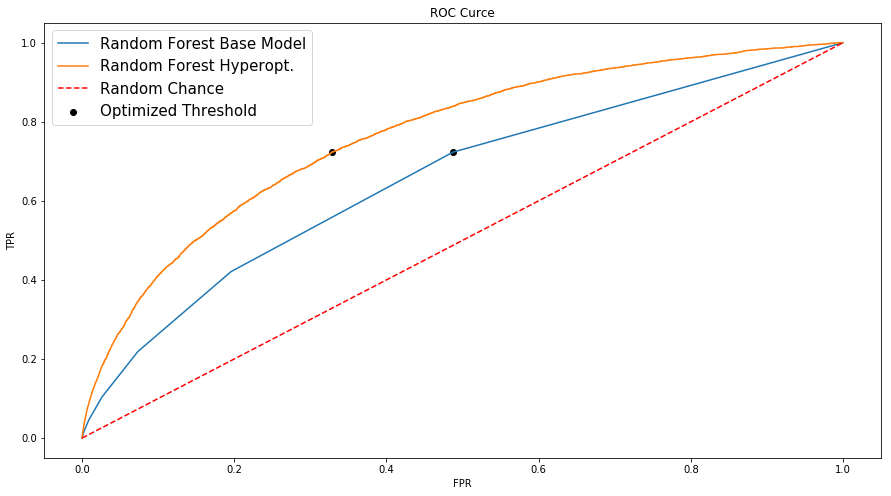

In [590]:
#Compare ROC AUC of basic model and grid search
plt.subplots(figsize=(15,8))

plt.plot(fpr_rf, tpr_rf, '')
plt.scatter(fpr_rf[ids[1]], tpr_rf[ids[1]], marker='o', color='black')

plt.plot(fpr_rfopti, tpr_rfopti, '')
plt.scatter(fpr_rfopti[ix_rf], tpr_rfopti[ix_rf], marker='o', color='black')

plt.plot([0,1],[0,1],'r--')

plt.legend(['Random Forest Base Model','Random Forest Hyperopt.', 'Random Chance', 'Optimized Threshold'], fontsize = 15)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curce')

#### XG Boost

In [223]:
scale_xg_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaler', 'model', 'scaler__copy', 'scaler__feature_range', 'model__objective', 'model__base_score', 'model__booster', 'model__colsample_bylevel', 'model__colsample_bynode', 'model__colsample_bytree', 'model__gamma', 'model__gpu_id', 'model__importance_type', 'model__interaction_constraints', 'model__learning_rate', 'model__max_delta_step', 'model__max_depth', 'model__min_child_weight', 'model__missing', 'model__monotone_constraints', 'model__n_estimators', 'model__n_jobs', 'model__num_parallel_tree', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__scale_pos_weight', 'model__subsample', 'model__tree_method', 'model__validate_parameters', 'model__verbosity'])

In [616]:
#determine whivh hparams will be used with intervals
space_xg = {'model__max_depth' : hp.quniform('model__max_depth', 5, 30, 1),
            'model__learning_rate' : hp.quniform('model__learning_rate', 0.01, 0.8, 0.01),
            'model__gamma' : hp.quniform('model__gamma', 0, 0.50, 0.01),
            'model__min_child_weight' : hp.quniform('model__min_child_weight', 1, 10, 1),
            'model__subsample' : hp.quniform('model__subsample', 0.1, 1, 0.01),
            'model__colsample_bytree' : hp.quniform('model__colsample_bytree', 0.1, 1.0, 0.01),
            'model__colsample_bylevel' : hp.quniform('model__colsample_bylevel', 0.1, 1.0, 0.01),
            'model__colsample_bynode' : hp.quniform('model__colsample_bynode', 0.1, 1.0, 0.01),
            'model__reg_lambda': hp.quniform('model__reg_lambda', 0, 1.0, 0.1),
            'model__tree_method': hp.choice('model__tree_method', ['auto', 'exact', 'approx', 'hist']),
            'model__max_delta_step': hp.quniform('model__max_delta_step', 0, 10, 1), 
            'model__random_sate': 100,
            'model__n_jobs': -1}

In [613]:
#Define function for xg boost model
def hyperparameter_tuning_xg(space_xg):
    roc_auc_sc = 0
    loss = 1 
    try:
        min_max_sc = MinMaxScaler()
        reg = xgb.XGBClassifier(max_depth = space_xg['model__max_depth'],
                                learning_rate = space_xg['model__learning_rate'],
                                gamma = space_xg['model__gamma'],
                                min_child_weight = space_xg['model__min_child_weight'],
                                subsample = space_xg['model__subsample'],
                                colsample_bytree = space_xg['model__colsample_bytree'],
                                colsample_bylevel = space_xg['model__colsample_bylevel'],
                                colsample_bynode = space_xg['model__colsample_bynode'],
                                reg_lambda = space_xg['model__reg_lambda'],
                                tree_method = space_xg['model__tree_method'],
                                max_delta_step = space_xg['model__max_delta_step'],   
                                random_state = space_xg['model__random_sate'],
                                n_jobs = space_xg['model__n_jobs'])
    
        scale_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', reg)])
        scale_pipeline.fit(X_train, y_train)
        
        y_pred_proba = scale_pipeline.predict_proba(X_test) #returns the predicted probability 
        roc_auc_sc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
        loss = 1 - roc_auc_sc
        print ("ROC AUC SCORE:", loss)
    except:    
        pass    
    #change the metric if you like
    return {'loss': loss, 'status': STATUS_OK}



In [620]:
SEED = 10
#search for best hparams
trials = Trials()
now = datetime.datetime.today()
print('search started at ', now)
best = fmin(fn = hyperparameter_tuning_xg,
            space = space_xg,
            algo = tpe.suggest,
            max_evals = 250,
            trials = trials,
            rstate = np.random.RandomState(SEED))

print(best)
print(space_eval(space_xg, best))

search started at  2020-05-25 23:09:14.692501
  0%|                                                                          | 0/250 [00:00<?, ?trial/s, best loss=?]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.36026715602445836                                                                                                    
  0%|▏                                           | 1/250 [02:12<9:08:43, 132.22s/trial, best loss: 0.36026715602445836]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3491036290481313                                                                                                     
  1%|▎                                            | 2/250 [02:48<7:07:51, 103.51s/trial, best loss: 0.3491036290481313]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3593575621022487                                                                                                     
  1%|▌                                            | 3/250 [04:37<7:12:12, 104.99s/trial, best loss: 0.3491036290481313]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25946049597856347                                                                                                    
  2%|▋                                           | 4/250 [06:42<7:36:02, 111.23s/trial, best loss: 0.25946049597856347]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2836302783689093                                                                                                     
  2%|▉                                           | 5/250 [10:03<9:23:31, 138.01s/trial, best loss: 0.25946049597856347]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.259267740129852                                                                                                      
  2%|█                                             | 6/250 [11:30<8:19:33, 122.84s/trial, best loss: 0.259267740129852]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2238560180854381                                                                                                     
  3%|█▎                                           | 7/250 [13:51<8:39:16, 128.22s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.33515851103758765                                                                                                    
  3%|█▍                                           | 8/250 [15:56<8:33:29, 127.31s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28603485919764415                                                                                                    
  4%|█▌                                           | 9/250 [18:02<8:29:54, 126.95s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3316258903699709                                                                                                     
  4%|█▊                                          | 10/250 [20:34<8:57:00, 134.25s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22665846440413295                                                                                                    
  4%|█▉                                          | 11/250 [23:31<9:45:37, 147.02s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3345442429498299                                                                                                     
  5%|██                                          | 12/250 [23:58<7:20:27, 111.04s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.37496264723551376                                                                                                    
  5%|██▎                                          | 13/250 [24:20<5:33:14, 84.36s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.323953038071929                                                                                                      
  6%|██▌                                          | 14/250 [26:23<6:17:52, 96.07s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2560047783374755                                                                                                     
  6%|██▋                                          | 15/250 [26:43<4:46:26, 73.13s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22598680321187103                                                                                                    
  6%|██▉                                          | 16/250 [29:22<6:26:17, 99.05s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.27108822210751815                                                                                                    
  7%|███                                          | 17/250 [29:44<4:54:49, 75.92s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.40192900235061035                                                                                                    
  7%|███▏                                         | 18/250 [32:01<6:04:06, 94.17s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3471467748061352                                                                                                     
  8%|███▍                                         | 19/250 [33:45<6:13:35, 97.04s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.31586655903420413                                                                                                    
  8%|███▌                                         | 20/250 [34:51<5:36:51, 87.88s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2744770781954642                                                                                                     
  8%|███▋                                        | 21/250 [39:23<9:06:17, 143.14s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3394769161742509                                                                                                     
  9%|███▊                                       | 22/250 [44:14<11:52:14, 187.43s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25962305663657326                                                                                                    
  9%|███▉                                       | 23/250 [48:57<13:37:34, 216.10s/trial, best loss: 0.2238560180854381]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22338149834907062                                                                                                    
 10%|████                                      | 24/250 [52:32<13:32:34, 215.73s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3282537570723314                                                                                                     
 10%|████▏                                     | 25/250 [54:12<11:18:22, 180.90s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.303549390253139                                                                                                      
 10%|████▎                                     | 26/250 [59:48<14:09:50, 227.64s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3477027499924925                                                                                                     
 11%|████▎                                   | 27/250 [1:03:40<14:10:23, 228.81s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3802700078751149                                                                                                     
 11%|████▍                                   | 28/250 [1:08:22<15:06:05, 244.89s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23325400959318088                                                                                                    
 12%|████▋                                   | 29/250 [1:09:43<12:01:01, 195.75s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.373929980812575                                                                                                      
 12%|████▊                                   | 30/250 [1:13:13<12:12:51, 199.87s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.40914614001747873                                                                                                    
 12%|████▉                                   | 31/250 [1:15:41<11:12:47, 184.33s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2717786439928478                                                                                                     
 13%|█████                                   | 32/250 [1:20:25<12:58:36, 214.30s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.29411913207203244                                                                                                    
 13%|█████▎                                  | 33/250 [1:24:53<13:53:31, 230.47s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3262902359563832                                                                                                     
 14%|█████▍                                  | 34/250 [1:25:35<10:25:57, 173.88s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24183057102618888                                                                                                    
 14%|█████▋                                   | 35/250 [1:28:03<9:55:29, 166.18s/trial, best loss: 0.22338149834907062]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2207975842437805                                                                                                     
 14%|██████                                    | 36/250 [1:29:31<8:28:25, 142.55s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3527448265318105                                                                                                     
 15%|██████▏                                   | 37/250 [1:33:06<9:43:26, 164.35s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28173084142338856                                                                                                    
 15%|██████▏                                  | 38/250 [1:36:11<10:02:31, 170.53s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22505594238060023                                                                                                    
 16%|██████▌                                   | 39/250 [1:38:14<9:09:07, 156.15s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.29655271582447473                                                                                                    
 16%|██████▋                                   | 40/250 [1:39:25<7:37:49, 130.81s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3024852323831352                                                                                                     
 16%|██████▉                                   | 41/250 [1:41:51<7:50:59, 135.21s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23057546660693973                                                                                                    
 17%|███████                                   | 42/250 [1:44:55<8:40:16, 150.08s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24672165536365775                                                                                                    
 17%|███████▏                                  | 43/250 [1:46:29<7:39:26, 133.17s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2551762769856889                                                                                                     
 18%|███████▍                                  | 44/250 [1:49:03<7:58:16, 139.30s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28708392994344867                                                                                                    
 18%|███████▌                                  | 45/250 [1:49:27<5:58:09, 104.83s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3144959347465095                                                                                                     
 18%|███████▋                                  | 46/250 [1:53:01<7:47:58, 137.64s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22375379653629668                                                                                                    
 19%|███████▉                                  | 47/250 [1:55:18<7:44:50, 137.39s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3134773556333219                                                                                                     
 19%|████████                                  | 48/250 [1:55:54<5:59:30, 106.79s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2792765392335885                                                                                                     
 20%|████████▏                                 | 49/250 [1:57:19<5:35:54, 100.27s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3437810552694365                                                                                                     
 20%|████████▍                                 | 50/250 [2:00:14<6:48:59, 122.70s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28586957423482695                                                                                                    
 20%|████████▌                                 | 51/250 [2:02:51<7:20:56, 132.95s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24628257903142892                                                                                                    
 21%|████████▋                                 | 52/250 [2:05:10<7:25:39, 135.05s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2222956789159095                                                                                                     
 21%|████████▉                                 | 53/250 [2:05:39<5:38:08, 102.99s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2871145273708049                                                                                                     
 22%|█████████▎                                 | 54/250 [2:05:59<4:15:03, 78.08s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3098244597067714                                                                                                     
 22%|█████████▍                                 | 55/250 [2:06:22<3:19:58, 61.53s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2720766843831042                                                                                                     
 22%|█████████▋                                 | 56/250 [2:06:49<2:46:01, 51.35s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2625084969424063                                                                                                     
 23%|█████████▊                                 | 57/250 [2:07:11<2:16:21, 42.39s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22688082003219767                                                                                                    
 23%|█████████▉                                 | 58/250 [2:07:34<1:57:49, 36.82s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28687584721727166                                                                                                    
 24%|██████████▏                                | 59/250 [2:07:54<1:41:13, 31.80s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2268049207919336                                                                                                     
 24%|██████████▎                                | 60/250 [2:08:21<1:36:02, 30.33s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.36875764856247584                                                                                                    
 24%|██████████▍                                | 61/250 [2:08:42<1:26:43, 27.53s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.39476465806406513                                                                                                    
 25%|██████████▋                                | 62/250 [2:11:05<3:14:47, 62.17s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.27528637762151564                                                                                                    
 25%|██████████▌                               | 63/250 [2:14:18<5:15:29, 101.23s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.34302837949877785                                                                                                    
 26%|███████████                                | 64/250 [2:14:52<4:11:28, 81.12s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23076515513035778                                                                                                    
 26%|███████████▏                               | 65/250 [2:16:35<4:30:13, 87.64s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22377631095670458                                                                                                    
 26%|███████████                               | 66/250 [2:20:04<6:20:41, 124.14s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24387837371985766                                                                                                    
 27%|███████████▎                              | 67/250 [2:23:48<7:49:28, 153.93s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28986997627216804                                                                                                    
 27%|███████████▍                              | 68/250 [2:27:32<8:51:10, 175.12s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22348219797047653                                                                                                    
 28%|███████████▎                             | 69/250 [2:31:49<10:02:18, 199.66s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3116698189310543                                                                                                     
 28%|███████████▍                             | 70/250 [2:35:31<10:18:42, 206.24s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22593917319254841                                                                                                    
 28%|███████████▉                              | 71/250 [2:38:18<9:40:18, 194.52s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3001804062446355                                                                                                     
 29%|████████████                              | 72/250 [2:38:45<7:08:24, 144.41s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3296779037491505                                                                                                     
 29%|████████████▎                             | 73/250 [2:43:29<9:08:57, 186.09s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2251589987332825                                                                                                     
 30%|████████████▍                             | 74/250 [2:45:13<7:53:48, 161.53s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2584205589656172                                                                                                     
 30%|████████████▌                             | 75/250 [2:47:32<7:31:19, 154.74s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23173135212673113                                                                                                    
 30%|████████████▊                             | 76/250 [2:48:41<6:14:47, 129.24s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.34379561955820026                                                                                                    
 31%|████████████▉                             | 77/250 [2:52:41<7:47:55, 162.28s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.26717268153305607                                                                                                    
 31%|█████████████                             | 78/250 [2:57:15<9:21:11, 195.76s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23530195491115724                                                                                                    
 32%|█████████████▎                            | 79/250 [2:58:29<7:33:52, 159.26s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22306148226110645                                                                                                    
 32%|█████████████▍                            | 80/250 [3:00:11<6:42:41, 142.13s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2564416932795681                                                                                                     
 32%|█████████████▌                            | 81/250 [3:01:53<6:06:06, 129.98s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22411595142721308                                                                                                    
 33%|█████████████▊                            | 82/250 [3:03:14<5:23:04, 115.39s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2277353674711019                                                                                                     
 33%|█████████████▉                            | 83/250 [3:04:53<5:07:27, 110.47s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2679611419229684                                                                                                     
 34%|██████████████                            | 84/250 [3:07:42<5:53:51, 127.90s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.40412324843340885                                                                                                    
 34%|██████████████▎                           | 85/250 [3:09:00<5:10:40, 112.97s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3621154107027176                                                                                                     
 34%|██████████████▍                           | 86/250 [3:10:13<4:36:02, 100.99s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.27288484534221624                                                                                                    
 35%|██████████████▌                           | 87/250 [3:13:03<5:31:06, 121.88s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2670373530908974                                                                                                     
 35%|██████████████▊                           | 88/250 [3:14:10<4:44:36, 105.41s/trial, best loss: 0.2207975842437805]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21843286456197042                                                                                                    
 36%|██████████████▉                           | 89/250 [3:15:32<4:24:01, 98.40s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21964527444175075                                                                                                    
 36%|███████████████                           | 90/250 [3:16:54<4:08:57, 93.36s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2508506055919081                                                                                                     
 36%|███████████████▎                          | 91/250 [3:17:59<3:45:00, 84.91s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2477451660282124                                                                                                     
 37%|███████████████▍                          | 92/250 [3:19:08<3:30:32, 79.95s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2876305110624525                                                                                                     
 37%|███████████████▌                          | 93/250 [3:21:15<4:06:10, 94.08s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2540171638236608                                                                                                     
 38%|███████████████▊                          | 94/250 [3:22:42<3:59:45, 92.22s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23510857548730946                                                                                                    
 38%|███████████████▉                          | 95/250 [3:24:39<4:17:21, 99.62s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2840749332974639                                                                                                     
 38%|███████████████▋                         | 96/250 [3:26:21<4:17:17, 100.25s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23594917643539914                                                                                                    
 39%|████████████████▎                         | 97/250 [3:27:54<4:10:21, 98.18s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24474497814830953                                                                                                    
 39%|████████████████                         | 98/250 [3:29:49<4:21:22, 103.18s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22514333822326005                                                                                                    
 40%|████████████████▏                        | 99/250 [3:31:25<4:14:09, 100.99s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.30680979672343134                                                                                                    
 40%|████████████████▍                        | 100/250 [3:32:54<4:03:41, 97.47s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24106794007887644                                                                                                    
 40%|████████████████▌                        | 101/250 [3:34:11<3:46:41, 91.29s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.31064104597116937                                                                                                    
 41%|████████████████▎                       | 102/250 [3:36:48<4:33:24, 110.84s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3444530259022842                                                                                                     
 41%|████████████████▍                       | 103/250 [3:38:55<4:43:36, 115.76s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2184517776283489                                                                                                     
 42%|████████████████▋                       | 104/250 [3:40:41<4:34:43, 112.90s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22727848043201437                                                                                                    
 42%|█████████████████▏                       | 105/250 [3:41:45<3:57:25, 98.25s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.37665067776688466                                                                                                    
 42%|████████████████▉                       | 106/250 [3:44:03<4:24:33, 110.23s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2252118747995966                                                                                                     
 43%|█████████████████▌                       | 107/250 [3:45:15<3:55:02, 98.62s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22469658978651774                                                                                                    
 43%|█████████████████▎                      | 108/250 [3:47:17<4:09:47, 105.54s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.27797529607477456                                                                                                    
 44%|█████████████████▍                      | 109/250 [3:48:58<4:05:18, 104.38s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23363396435873007                                                                                                    
 44%|██████████████████                       | 110/250 [3:50:03<3:35:56, 92.54s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23669943300894547                                                                                                    
 44%|██████████████████▏                      | 111/250 [3:51:08<3:14:45, 84.07s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25832442223882435                                                                                                    
 45%|██████████████████▎                      | 112/250 [3:53:00<3:33:03, 92.63s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22828088269907965                                                                                                    
 45%|██████████████████                      | 113/250 [3:55:21<4:04:44, 107.19s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25676911030532446                                                                                                    
 46%|██████████████████▋                      | 114/250 [3:56:41<3:43:59, 98.82s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24512816741650512                                                                                                    
 46%|██████████████████▊                      | 115/250 [3:57:46<3:20:03, 88.91s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25431096484178384                                                                                                    
 46%|███████████████████                      | 116/250 [3:59:20<3:21:48, 90.36s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3151965309805299                                                                                                     
 47%|█████████████████▊                    | 117/250 [5:07:51<47:54:14, 1296.65s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3269178720940936                                                                                                     
 47%|█████████████████▉                    | 118/250 [5:29:15<47:24:05, 1292.77s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23718578406348834                                                                                                    
 48%|█████████████████▌                   | 119/250 [7:45:39<122:15:57, 3359.98s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25604991658377263                                                                                                    
 48%|██████████████████▏                   | 120/250 [7:57:04<92:21:10, 2557.46s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2909963421710777                                                                                                     
 48%|█████████████████▉                   | 121/250 [9:30:54<124:40:40, 3479.38s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.36913440204420445                                                                                                    
 49%|██████████████████▌                   | 122/250 [9:33:00<87:56:26, 2473.33s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3385045170064155                                                                                                     
 49%|██████████████████▋                   | 123/250 [9:36:24<63:14:24, 1792.63s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2192424936487627                                                                                                     
 50%|██████████████████▊                   | 124/250 [9:38:30<45:14:40, 1292.70s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22302725026089498                                                                                                    
 50%|███████████████████▌                   | 125/250 [9:40:17<32:31:57, 936.94s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2680741245663686                                                                                                     
 50%|███████████████████▋                   | 126/250 [9:42:25<23:54:29, 694.11s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22586416797199327                                                                                                    
 51%|███████████████████▊                   | 127/250 [9:44:12<17:41:53, 517.99s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2800357403371144                                                                                                     
 51%|███████████████████▉                   | 128/250 [9:47:00<13:59:53, 413.06s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2326835853007284                                                                                                     
 52%|████████████████████▋                   | 129/250 [9:47:26<9:58:44, 296.90s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22802722085501248                                                                                                    
 52%|████████████████████▊                   | 130/250 [9:49:17<8:02:19, 241.17s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3585153132115292                                                                                                     
 52%|████████████████████▉                   | 131/250 [9:51:30<6:53:39, 208.57s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.4160515385001745                                                                                                     
 53%|█████████████████████                   | 132/250 [9:54:12<6:23:11, 194.85s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.37230861757642875                                                                                                    
 53%|█████████████████████▎                  | 133/250 [9:57:48<6:32:14, 201.15s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2296142361861303                                                                                                     
 54%|█████████████████████▍                  | 134/250 [9:58:08<4:43:48, 146.79s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24661201807268207                                                                                                    
 54%|█████████████████████                  | 135/250 [10:00:04<4:23:41, 137.58s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3840453520051098                                                                                                     
 54%|█████████████████████▏                 | 136/250 [10:03:04<4:45:15, 150.13s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2288942701268737                                                                                                     
 55%|█████████████████████▎                 | 137/250 [10:05:12<4:30:29, 143.62s/trial, best loss: 0.21843286456197042]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2184297391037311                                                                                                     
 55%|██████████████████████                  | 138/250 [10:06:59<4:07:21, 132.52s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.320697953113135                                                                                                      
 56%|██████████████████████▏                 | 139/250 [10:07:32<3:09:57, 102.68s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2373544674566368                                                                                                     
 56%|██████████████████████▉                  | 140/250 [10:09:01<3:00:47, 98.61s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.26094725761490745                                                                                                    
 56%|██████████████████████▌                 | 141/250 [10:11:00<3:10:31, 104.88s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2194536390062688                                                                                                     
 57%|██████████████████████▋                 | 142/250 [10:12:52<3:12:07, 106.74s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.31298974659628065                                                                                                    
 57%|██████████████████████▉                 | 143/250 [10:18:17<5:07:27, 172.41s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.239235994038821                                                                                                      
 58%|███████████████████████                 | 144/250 [10:20:17<4:36:32, 156.53s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3565963620110939                                                                                                     
 58%|███████████████████████▏                | 145/250 [10:20:49<3:28:36, 119.21s/trial, best loss: 0.2184297391037311]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21835177163047337                                                                                                    
 58%|██████████████████████▊                | 146/250 [10:22:38<3:21:31, 116.27s/trial, best loss: 0.21835177163047337]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21933779882168258                                                                                                    
 59%|██████████████████████▉                | 147/250 [10:24:27<3:15:38, 113.96s/trial, best loss: 0.21835177163047337]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25119887393032636                                                                                                    
 59%|███████████████████████                | 148/250 [10:26:57<3:32:19, 124.90s/trial, best loss: 0.21835177163047337]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21803937312481902                                                                                                    
 60%|███████████████████████▏               | 149/250 [10:28:18<3:08:10, 111.79s/trial, best loss: 0.21803937312481902]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2177297487522114                                                                                                     
 60%|████████████████████████                | 150/250 [10:29:58<3:00:03, 108.03s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22875413325964877                                                                                                    
 60%|████████████████████████▏               | 151/250 [10:32:38<3:24:06, 123.70s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24884692977571377                                                                                                    
 61%|████████████████████████▎               | 152/250 [10:35:12<3:37:00, 132.86s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22095873057416493                                                                                                    
 61%|████████████████████████▍               | 153/250 [10:37:18<3:31:14, 130.67s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21787413474057293                                                                                                    
 62%|████████████████████████▋               | 154/250 [10:39:56<3:42:18, 138.94s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22671907504079658                                                                                                    
 62%|████████████████████████▊               | 155/250 [10:43:41<4:20:49, 164.73s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2232740256978989                                                                                                     
 62%|████████████████████████▉               | 156/250 [10:46:54<4:31:37, 173.37s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2693602423271184                                                                                                     
 63%|█████████████████████████               | 157/250 [10:51:15<5:09:13, 199.50s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22889751726711682                                                                                                    
 63%|█████████████████████████▎              | 158/250 [10:53:28<4:35:15, 179.52s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22720784384815484                                                                                                    
 64%|█████████████████████████▍              | 159/250 [10:56:20<4:28:54, 177.31s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2199902523110222                                                                                                     
 64%|█████████████████████████▌              | 160/250 [10:58:34<4:06:18, 164.20s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.30147568626310495                                                                                                    
 64%|█████████████████████████▊              | 161/250 [11:02:27<4:34:34, 185.11s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23254796944350975                                                                                                    
 65%|█████████████████████████▉              | 162/250 [11:05:55<4:41:34, 191.99s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2317550602584304                                                                                                     
 65%|██████████████████████████              | 163/250 [11:08:04<4:10:39, 172.87s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.27337891002480497                                                                                                    
 66%|██████████████████████████▏             | 164/250 [11:08:41<3:09:37, 132.29s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21975503124828533                                                                                                    
 66%|██████████████████████████▍             | 165/250 [11:12:26<3:46:50, 160.12s/trial, best loss: 0.2177297487522114]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21771669483680878                                                                                                    
 66%|█████████████████████████▉             | 166/250 [11:14:53<3:38:27, 156.04s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23491514226340648                                                                                                    
 67%|██████████████████████████             | 167/250 [11:17:12<3:28:47, 150.93s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2820936581633058                                                                                                     
 67%|██████████████████████████▏            | 168/250 [11:21:33<4:11:35, 184.09s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23456447422588256                                                                                                    
 68%|██████████████████████████▎            | 169/250 [11:23:06<3:31:30, 156.68s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2964377328300294                                                                                                     
 68%|██████████████████████████▌            | 170/250 [11:25:19<3:19:27, 149.59s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22550178307681412                                                                                                    
 68%|██████████████████████████▋            | 171/250 [11:25:47<2:28:57, 113.13s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2191020910309296                                                                                                     
 69%|██████████████████████████▊            | 172/250 [11:27:26<2:21:21, 108.74s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3044215331986809                                                                                                     
 69%|██████████████████████████▉            | 173/250 [11:32:56<3:44:49, 175.18s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28857558160762686                                                                                                    
 70%|███████████████████████████▏           | 174/250 [11:34:29<3:10:47, 150.63s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24188958318738707                                                                                                    
 70%|███████████████████████████▎           | 175/250 [11:35:51<2:42:31, 130.02s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.30128647832944166                                                                                                    
 70%|███████████████████████████▍           | 176/250 [11:38:45<2:56:34, 143.17s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22466630541048938                                                                                                    
 71%|███████████████████████████▌           | 177/250 [11:40:58<2:50:27, 140.11s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3049293230336023                                                                                                     
 71%|███████████████████████████▊           | 178/250 [11:41:25<2:07:28, 106.23s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23816271182388815                                                                                                    
 72%|███████████████████████████▉           | 179/250 [11:43:14<2:06:27, 106.87s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22740716871971134                                                                                                    
 72%|████████████████████████████           | 180/250 [11:45:49<2:21:40, 121.43s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2847357535980698                                                                                                     
 72%|████████████████████████████▏          | 181/250 [11:47:35<2:14:20, 116.83s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23132020668892206                                                                                                    
 73%|████████████████████████████▍          | 182/250 [11:51:10<2:45:54, 146.38s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2969819463855312                                                                                                     
 73%|████████████████████████████▌          | 183/250 [11:55:24<3:19:20, 178.51s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21820487076033768                                                                                                    
 74%|████████████████████████████▋          | 184/250 [11:57:11<2:52:47, 157.09s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.39743256669309046                                                                                                    
 74%|████████████████████████████▊          | 185/250 [12:01:17<3:19:12, 183.88s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22165631653261453                                                                                                    
 74%|█████████████████████████████          | 186/250 [12:01:44<2:25:40, 136.57s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2866627502537369                                                                                                     
 75%|█████████████████████████████▏         | 187/250 [12:06:05<3:02:37, 173.93s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3175780861077957                                                                                                     
 75%|█████████████████████████████▎         | 188/250 [12:08:17<2:46:48, 161.43s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2983687171891156                                                                                                     
 76%|█████████████████████████████▍         | 189/250 [12:10:32<2:36:02, 153.49s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24892532873263573                                                                                                    
 76%|█████████████████████████████▋         | 190/250 [12:13:23<2:38:39, 158.65s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2559222371373788                                                                                                     
 76%|█████████████████████████████▊         | 191/250 [12:16:04<2:36:48, 159.46s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2783482893298277                                                                                                     
 77%|█████████████████████████████▉         | 192/250 [12:17:39<2:15:20, 140.01s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25658634068564745                                                                                                    
 77%|██████████████████████████████         | 193/250 [12:21:20<2:36:17, 164.52s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2255447151597746                                                                                                     
 78%|██████████████████████████████▎        | 194/250 [12:23:39<2:26:12, 156.65s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3664868110601798                                                                                                     
 78%|██████████████████████████████▍        | 195/250 [12:24:10<1:49:03, 118.97s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.33413111738113077                                                                                                    
 78%|██████████████████████████████▌        | 196/250 [12:26:23<1:50:54, 123.23s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3533179054417509                                                                                                     
 79%|██████████████████████████████▋        | 197/250 [12:34:22<3:23:11, 230.03s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.315236584218927                                                                                                      
 79%|██████████████████████████████▉        | 198/250 [12:36:56<2:59:38, 207.28s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21860565336872573                                                                                                    
 80%|███████████████████████████████        | 199/250 [12:38:24<2:25:46, 171.50s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21825935360682336                                                                                                    
 80%|███████████████████████████████▏       | 200/250 [12:39:47<2:00:40, 144.81s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22212823256295589                                                                                                    
 80%|███████████████████████████████▎       | 201/250 [12:42:18<1:59:52, 146.78s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.29809584764212604                                                                                                    
 81%|███████████████████████████████▌       | 202/250 [12:45:53<2:13:44, 167.19s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22665642577922318                                                                                                    
 81%|███████████████████████████████▋       | 203/250 [12:46:27<1:39:42, 127.29s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2376504963025482                                                                                                     
 82%|███████████████████████████████▊       | 204/250 [12:48:06<1:30:58, 118.66s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25119322745205164                                                                                                    
 82%|███████████████████████████████▉       | 205/250 [12:51:32<1:48:38, 144.87s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2666186713124725                                                                                                     
 82%|████████████████████████████████▏      | 206/250 [12:53:59<1:46:42, 145.52s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22272817755951269                                                                                                    
 83%|████████████████████████████████▎      | 207/250 [12:55:31<1:32:46, 129.46s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.26815668743091703                                                                                                    
 83%|████████████████████████████████▍      | 208/250 [12:57:11<1:24:33, 120.79s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.38916822214541646                                                                                                    
 84%|████████████████████████████████▌      | 209/250 [13:02:12<1:59:32, 174.93s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22620671039581364                                                                                                    
 84%|████████████████████████████████▊      | 210/250 [13:06:57<2:18:31, 207.79s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25763338291661964                                                                                                    
 84%|████████████████████████████████▉      | 211/250 [13:07:19<1:38:48, 152.02s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.25059400929785125                                                                                                    
 85%|█████████████████████████████████      | 212/250 [13:08:47<1:24:11, 132.93s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.30623045534263804                                                                                                    
 85%|█████████████████████████████████▏     | 213/250 [13:13:46<1:52:34, 182.56s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2419993970436447                                                                                                     
 86%|█████████████████████████████████▍     | 214/250 [13:17:02<1:52:05, 186.82s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24386344402400773                                                                                                    
 86%|█████████████████████████████████▌     | 215/250 [13:18:54<1:35:48, 164.24s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.21897548361382324                                                                                                    
 86%|█████████████████████████████████▋     | 216/250 [13:20:53<1:25:27, 150.81s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2549740046654714                                                                                                     
 87%|█████████████████████████████████▊     | 217/250 [13:23:38<1:25:12, 154.91s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.29708323130820846                                                                                                    
 87%|██████████████████████████████████     | 218/250 [13:27:58<1:39:26, 186.44s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.294371830209071                                                                                                      
 88%|██████████████████████████████████▏    | 219/250 [13:28:29<1:12:11, 139.74s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22146569932636495                                                                                                    
 88%|██████████████████████████████████▎    | 220/250 [13:30:25<1:06:19, 132.66s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.31880751738624247                                                                                                    
 88%|██████████████████████████████████▍    | 221/250 [13:33:14<1:09:28, 143.73s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2639012294420384                                                                                                     
 89%|██████████████████████████████████▋    | 222/250 [13:35:00<1:01:40, 132.17s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.24134993541509187                                                                                                    
 89%|████████████████████████████████████▌    | 223/250 [13:35:45<47:42, 106.03s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2402294709128392                                                                                                     
 90%|████████████████████████████████████▋    | 224/250 [13:38:05<50:22, 116.24s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28144167407042087                                                                                                    
 90%|████████████████████████████████████▉    | 225/250 [13:39:29<44:24, 106.60s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28473421614414374                                                                                                    
 90%|█████████████████████████████████████    | 226/250 [13:42:28<51:22, 128.46s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3419978549679691                                                                                                     
 91%|█████████████████████████████████████▏   | 227/250 [13:44:35<49:02, 127.92s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.26080547244397856                                                                                                    
 91%|██████████████████████████████████████▎   | 228/250 [13:45:05<36:07, 98.50s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2205283770723594                                                                                                     
 92%|██████████████████████████████████████▍   | 229/250 [13:46:27<32:47, 93.71s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23221523632236785                                                                                                    
 92%|█████████████████████████████████████▋   | 230/250 [13:49:19<39:02, 117.14s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22118701287408027                                                                                                    
 92%|█████████████████████████████████████▉   | 231/250 [13:51:09<36:27, 115.12s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23546591112093385                                                                                                    
 93%|██████████████████████████████████████   | 232/250 [13:53:30<36:50, 122.80s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22154960755336706                                                                                                    
 93%|██████████████████████████████████████▏  | 233/250 [13:55:04<32:17, 113.97s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3068877930826249                                                                                                     
 94%|██████████████████████████████████████▍  | 234/250 [13:56:30<28:11, 105.72s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.260782595505078                                                                                                      
 94%|███████████████████████████████████████▍  | 235/250 [13:56:57<20:32, 82.14s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.29074023477148203                                                                                                    
 94%|██████████████████████████████████████▋  | 236/250 [14:00:48<29:33, 126.68s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.35662900817343723                                                                                                    
 95%|██████████████████████████████████████▊  | 237/250 [14:04:46<34:43, 160.27s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3448515218277901                                                                                                     
 95%|███████████████████████████████████████  | 238/250 [14:06:44<29:27, 147.32s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23649298883746916                                                                                                    
 96%|███████████████████████████████████████▏ | 239/250 [14:09:00<26:26, 144.21s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28417984159969656                                                                                                    
 96%|███████████████████████████████████████▎ | 240/250 [14:12:03<25:56, 155.61s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22223998213797735                                                                                                    
 96%|███████████████████████████████████████▌ | 241/250 [14:14:23<22:39, 151.05s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22351127960835848                                                                                                    
 97%|███████████████████████████████████████▋ | 242/250 [14:18:23<23:42, 177.80s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23180701955736138                                                                                                    
 97%|███████████████████████████████████████▊ | 243/250 [14:18:48<15:22, 131.73s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3018341795006012                                                                                                     
 98%|████████████████████████████████████████ | 244/250 [14:20:22<12:03, 120.65s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28883412734126723                                                                                                    
 98%|████████████████████████████████████████▏| 245/250 [14:21:44<09:05, 109.05s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.28689621216299166                                                                                                    
 98%|████████████████████████████████████████▎| 246/250 [14:23:14<06:52, 103.10s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2933490279720887                                                                                                     
 99%|████████████████████████████████████████▌| 247/250 [14:24:57<05:09, 103.12s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22164765111298834                                                                                                    
 99%|████████████████████████████████████████▋| 248/250 [14:28:24<04:28, 134.34s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2272471449690019                                                                                                     
100%|████████████████████████████████████████▊| 249/250 [14:31:02<02:21, 141.35s/trial, best loss: 0.21771669483680878]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.22009057424881917                                                                                                    
100%|█████████████████████████████████████████| 250/250 [14:32:33<00:00, 209.41s/trial, best loss: 0.21771669483680878]
{'model__colsample_bylevel': 0.56, 'model__colsample_bynode': 0.68, 'model__colsample_bytree': 0.79, 'model__gamma': 0.28, 'model__learning_rate': 0.09, 'model__max_delta_step': 6.0, 'model__max_depth': 6.0, 'model__min_child_weight': 5.0, 'model__reg_lambda': 0.9, 'model__subsample': 0.93, 'model__tree_method': 2}
{'model__colsample_bylevel': 0.56, 'model__colsample_bynode': 0.68, 'model__colsample_bytree': 0.79, 'model__gamma': 0.28, 'model__learning_rate': 0.09, 'model__max_delta_step': 6.0, 'model__max_depth': 6.0, 'model__min_child_weight': 5.0, 'model__n_jobs': -1, 'model__random_sate': 100, 'model__reg_lambda': 0.9, 'model__s

In [629]:
#determine whivh hparams will be used with intervals
space_xg_v2 = {'model__n_estimators': hp.quniform('model__n_estimators', 100, 1500, 50),
                'model__max_depth' : 6,
                'model__learning_rate' : 0.09,
                'model__gamma' : 0.28,
                'model__min_child_weight' : 5,
                'model__subsample' : 0.93,
                'model__colsample_bytree' : 0.79,
                'model__colsample_bylevel' : 0.56,
                'model__colsample_bynode' : 0.68,
                'model__reg_lambda': 0.9,
                'model__tree_method': 'approx',
                'model__max_delta_step': 6, 
                'model__random_sate': 100,
                'model__n_jobs': -1}

In [634]:
#Define function for xg boost model
def hyperparameter_tuning_xg_v2(space_xg_v2):
    roc_auc_sc = 0
    loss = 1 
    try:
        min_max_sc = MinMaxScaler()
        reg = xgb.XGBClassifier(n_estimators = int(space_xg_v2['model__n_estimators']),
                                max_depth = space_xg_v2['model__max_depth'],
                                learning_rate = space_xg_v2['model__learning_rate'],
                                gamma = space_xg_v2['model__gamma'],
                                min_child_weight = space_xg_v2['model__min_child_weight'],
                                subsample = space_xg_v2['model__subsample'],
                                colsample_bytree = space_xg_v2['model__colsample_bytree'],
                                colsample_bylevel = space_xg_v2['model__colsample_bylevel'],
                                colsample_bynode = space_xg_v2['model__colsample_bynode'],
                                reg_lambda = space_xg_v2['model__reg_lambda'],
                                tree_method = space_xg_v2['model__tree_method'],
                                max_delta_step = space_xg_v2['model__max_delta_step'],   
                                random_state = space_xg_v2['model__random_sate'],
                                n_jobs = space_xg_v2['model__n_jobs'])
    
        scale_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', reg)])
        scale_pipeline.fit(X_train, y_train)
        
        y_pred_proba = scale_pipeline.predict_proba(X_test) #returns the predicted probability 
        roc_auc_sc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
        loss = 1 - roc_auc_sc
        print ("ROC AUC SCORE:", loss)
    except:    
        pass    
    #change the metric if you like
    return {'loss': loss, 'status': STATUS_OK}

In [635]:
SEED = 10
#search for best hparams
trials = Trials()
now = datetime.datetime.today()
print('search started at ', now)
best = fmin(fn = hyperparameter_tuning_xg_v2,
            space = space_xg_v2,
            algo = tpe.suggest,
            max_evals = 15,
            trials = trials,
            rstate = np.random.RandomState(SEED))

print(best)
print(space_eval(space_xg_v2, best))

search started at  2020-05-26 15:42:33.674706
  0%|                                                                           | 0/15 [00:00<?, ?trial/s, best loss=?]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23624897164624725                                                                                                    
  7%|███▏                                           | 1/15 [03:56<55:08, 236.32s/trial, best loss: 0.23624897164624725]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2228758088827465                                                                                                     
 13%|██████▍                                         | 2/15 [06:23<45:26, 209.70s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.306753061857186                                                                                                      
 20%|█████████▏                                    | 3/15 [31:48<2:00:50, 604.21s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2932694082233105                                                                                                     
 27%|████████████▎                                 | 4/15 [49:56<2:17:23, 749.37s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.30350786924813566                                                                                                    
 33%|██████████████▋                             | 5/15 [1:11:01<2:30:39, 903.99s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.306753061857186                                                                                                      
 40%|█████████████████▏                         | 6/15 [1:35:31<2:41:04, 1073.82s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.30350786924813566                                                                                                    
 47%|████████████████████                       | 7/15 [1:55:57<2:29:16, 1119.60s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.26634164327396936                                                                                                    
 53%|███████████████████████▍                    | 8/15 [2:04:37<1:49:37, 939.58s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.2687917241453459                                                                                                     
 60%|██████████████████████████▍                 | 9/15 [2:14:12<1:23:01, 830.22s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.27658738427673124                                                                                                    
 67%|████████████████████████████▋              | 10/15 [2:26:47<1:07:18, 807.66s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3008973540846891                                                                                                     
 73%|███████████████████████████████▌           | 11/15 [2:46:45<1:01:38, 924.63s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3008973540846891                                                                                                     
 80%|███████████████████████████████████▏        | 12/15 [3:06:46<50:22, 1007.52s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.26244638243171714                                                                                                    
 87%|███████████████████████████████████████      | 13/15 [3:14:45<28:18, 849.20s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.3044496742382826                                                                                                     
 93%|█████████████████████████████████████████   | 14/15 [3:37:31<16:44, 1004.12s/trial, best loss: 0.2228758088827465]

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



ROC AUC SCORE:                                                                                                         
0.23624897164624725                                                                                                    
100%|█████████████████████████████████████████████| 15/15 [3:41:29<00:00, 885.99s/trial, best loss: 0.2228758088827465]
{'model__n_estimators': 150.0}
{'model__colsample_bylevel': 0.56, 'model__colsample_bynode': 0.68, 'model__colsample_bytree': 0.79, 'model__gamma': 0.28, 'model__learning_rate': 0.09, 'model__max_delta_step': 6, 'model__max_depth': 6, 'model__min_child_weight': 5, 'model__n_estimators': 150.0, 'model__n_jobs': -1, 'model__random_sate': 100, 'model__reg_lambda': 0.9, 'model__subsample': 0.93, 'model__tree_method': 'approx'}


In [636]:
xgb_opti = xgb.XGBClassifier(n_estimators = 150,
                             colsample_bylevel = 0.56,
                             colsample_bynode = 0.68,
                             colsample_bytree = 0.79,
                             gamma = 0.28,
                             learning_rate = 0.09,
                             max_delta_step = 6,
                             max_depth = 6,
                             min_child_weight = 5,
                             reg_lambda = 0.9,
                             subsample = 0.93,
                             tree_method = 'approx',
                             random_state = 100,
                             n_jobs = -1)

scale_xgbopti_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', xgb_opti)])

scale_xgbopti_pipeline.fit(X_train, y_train) 

y_pred_xgbopti = scale_xgbopti_pipeline.predict(X_test) #predict y using pipeline
y_pred_proba_xgbopti = scale_xgbopti_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_xgbopti = y_pred_proba_xgbopti[:,1] #array of positive probability
neg_proba_xgbopti = y_pred_proba_xgbopti[:,0] #array of negative probability

#ROC AUC Score
print(roc_auc_score(y_test, pos_proba_xgbopti))

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7771241911172535


In [638]:
#Improvement in ROC AUC from base model after tunning:
print('Due to the running we improved the Random Forest Classifier by {} percent'.format(roc_auc_score(y_test, pos_proba_xgbopti) / roc_auc_score(y_test, pos_proba_xg) - 1))

Due to the running we improved the Random Forest Classifier by 0.10010732886377238 percent


In [645]:
#Get TPR and FPR and threshold values to plot curve:
fpr_xgbopti, tpr_xgbopti, threshold_xgbopti = metrics.roc_curve(y_test, pos_proba_xgbopti
                                           ,sample_weight = compute_sample_weight(class_weight = 'balanced', y = y_test)
                                           #,drop_intermediate = False
                                           )

#G-Mean = sqrt(Sensitivity * Specificity)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr_xgbopti * (1 - fpr_xgbopti))

# locate the index of the largest g-mean
ix_xgb = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (threshold_xgbopti[ix_xgb], gmeans[ix_xgb]))

y_pred_new = np.where(pos_proba_xgbopti > threshold_xgbopti[ix_xgb], 1, 0)

TP_new = metrics.confusion_matrix(y_test, y_pred_new)[1][1] / (metrics.confusion_matrix(y_test, y_pred_new)[1][1] + metrics.confusion_matrix(y_test, y_pred_new)[1][0])
FP_new = metrics.confusion_matrix(y_test, y_pred_new)[0][1] / (metrics.confusion_matrix(y_test, y_pred_new)[0][0] + metrics.confusion_matrix(y_test, y_pred_new)[0][1])
TN_new = metrics.confusion_matrix(y_test, y_pred_new)[0][0] / (metrics.confusion_matrix(y_test, y_pred_new)[0][0] + metrics.confusion_matrix(y_test, y_pred_new)[0][1])
FN_new = metrics.confusion_matrix(y_test, y_pred_new)[1][0] / (metrics.confusion_matrix(y_test, y_pred_new)[1][1] + metrics.confusion_matrix(y_test, y_pred_new)[1][0])

print('TP Rate:', TP_new)
print('FN Rate:', FN_new)
print('FP Rate:', FP_new)
print('TN Rate:', TN_new)

Best Threshold=0.012361, G-Mean=0.712
TP Rate: 0.729887745556595
FN Rate: 0.27011225444340503
FP Rate: 0.30491532960314227
TN Rate: 0.6950846703968577


In [643]:
#Return Classification Report:
print(classification_report(y_test, y_pred_xg, labels=[1]))
print(classification_report(y_test, y_pred_new, labels=[1]))

              precision    recall  f1-score   support

           1       0.02      0.63      0.05      4276

   micro avg       0.02      0.63      0.05      4276
   macro avg       0.02      0.63      0.05      4276
weighted avg       0.02      0.63      0.05      4276

              precision    recall  f1-score   support

           1       0.01      1.00      0.03      4276

   micro avg       0.01      1.00      0.03      4276
   macro avg       0.01      1.00      0.03      4276
weighted avg       0.01      1.00      0.03      4276



Text(0.5, 1.0, 'ROC Curce')

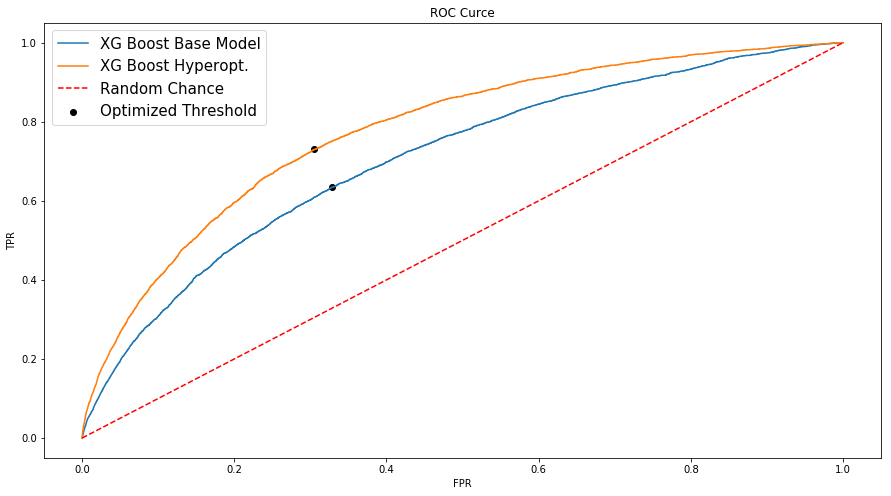

In [644]:
#Compare ROC AUC of basic model and grid search
plt.subplots(figsize=(15,8))

plt.plot(fpr_xg, tpr_xg, '')
plt.scatter(fpr_xg[ids[2]], tpr_xg[ids[2]], marker='o', color='black')

plt.plot(fpr_xgbopti, tpr_xgbopti, '')
plt.scatter(fpr_xgbopti[ix_xgb], tpr_xgbopti[ix_xgb], marker='o', color='black')

plt.plot([0,1],[0,1],'r--')

plt.legend(['XG Boost Base Model','XG Boost Hyperopt.', 'Random Chance', 'Optimized Threshold'], fontsize = 15)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curce')

### Comparing tunned models

Text(0, 0.5, 'TPR')

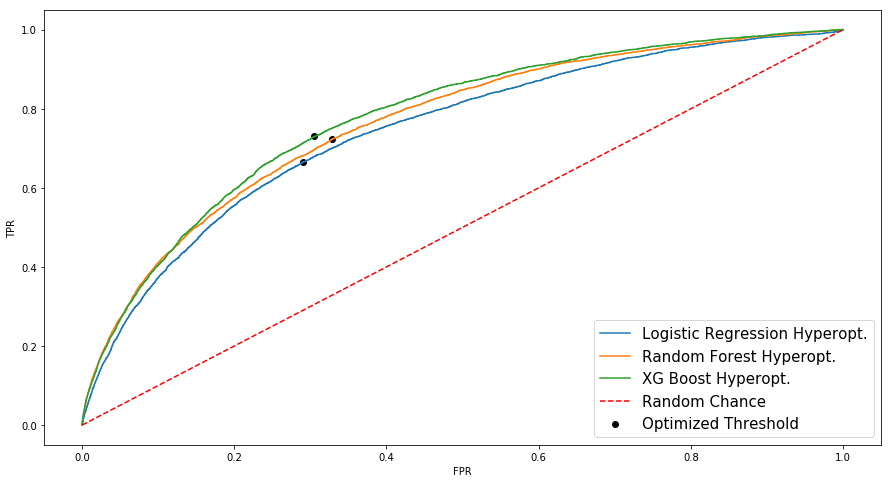

In [653]:
#Compare ROC AUC of basic model and grid search
plt.subplots(figsize=(15,8))

plt.plot(fpr_lrgrid, tpr_lrgrid, '')
plt.scatter(fpr_lrgrid[ix_lr_opti], tpr_lrgrid[ix_lr_opti], marker = 'o', color = 'black')

plt.plot(fpr_rfopti, tpr_rfopti, '')
plt.scatter(fpr_rfopti[ix_rf], tpr_rfopti[ix_rf], marker = 'o', color = 'black')

plt.plot(fpr_xgbopti, tpr_xgbopti, '')
plt.scatter(fpr_xgbopti[ix_xgb], tpr_xgbopti[ix_xgb], marker='o', color='black')

plt.plot([0,1],[0,1],'r--')

plt.legend(['Logistic Regression Hyperopt.', 'Random Forest Hyperopt.', 'XG Boost Hyperopt.', 'Random Chance', 'Optimized Threshold'], fontsize = 15)
plt.xlabel('FPR')
plt.ylabel('TPR')

### Comparing feature importance of different models

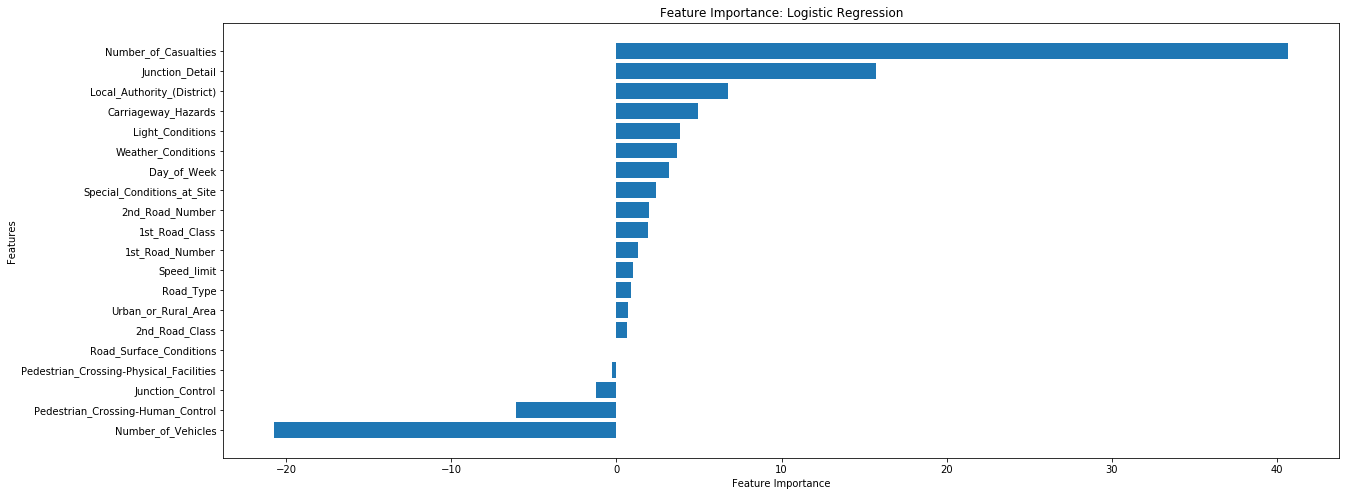

In [665]:
#To create the list of Importance used for the Importance plot
imp = np.array(scale_lrgrid_pipeline.steps[1][1].coef_).reshape(-1,1)

impor = [None] * len(imp)

for i,v in enumerate(imp):
    impor[i] = imp[i][0]
    
#Plotting the feature importacne from the basic LGR model
plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 10})

names = features.columns

impor2, names = zip(*sorted(zip(impor, names)))

plt.barh(range(len(names)),impor2, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Logistic Regression')
plt.show()

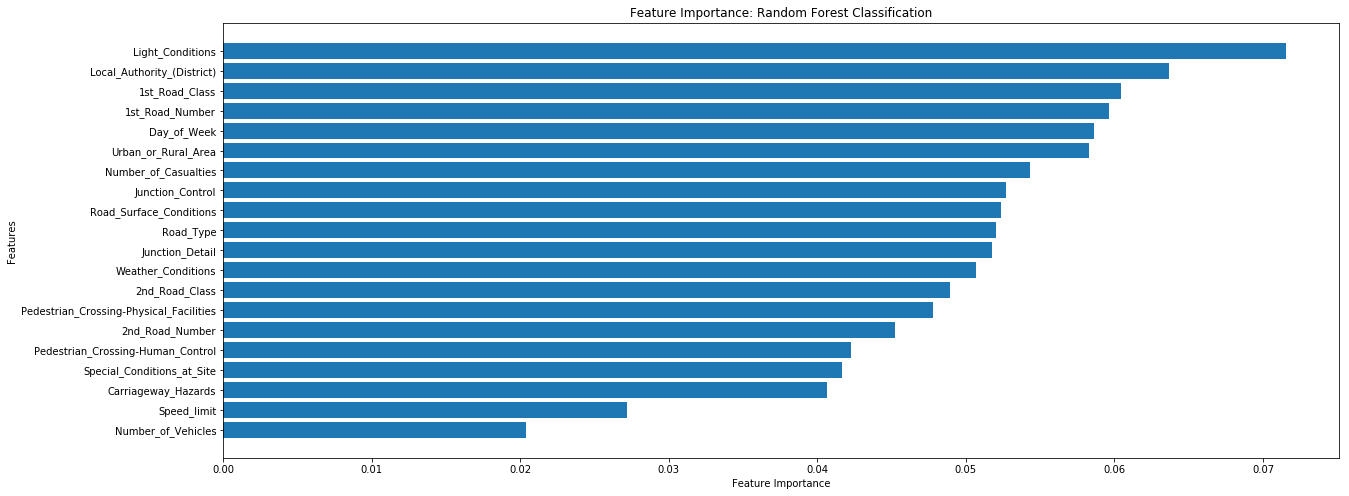

In [668]:
#To create the list of Importance used for the Importance plot
imp = np.array(scale_rfopti_pipeline.steps[1][1].feature_importances_).reshape(-1,1)

impor = [None] * len(imp)

for i,v in enumerate(imp):
    impor[i] = imp[i][0]
    
#Plotting the feature importacne from the basic LGR model
plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 10})

names = features.columns

impor2, names = zip(*sorted(zip(impor, names)))

plt.barh(range(len(names)),impor2, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Random Forest Classification')
plt.show()

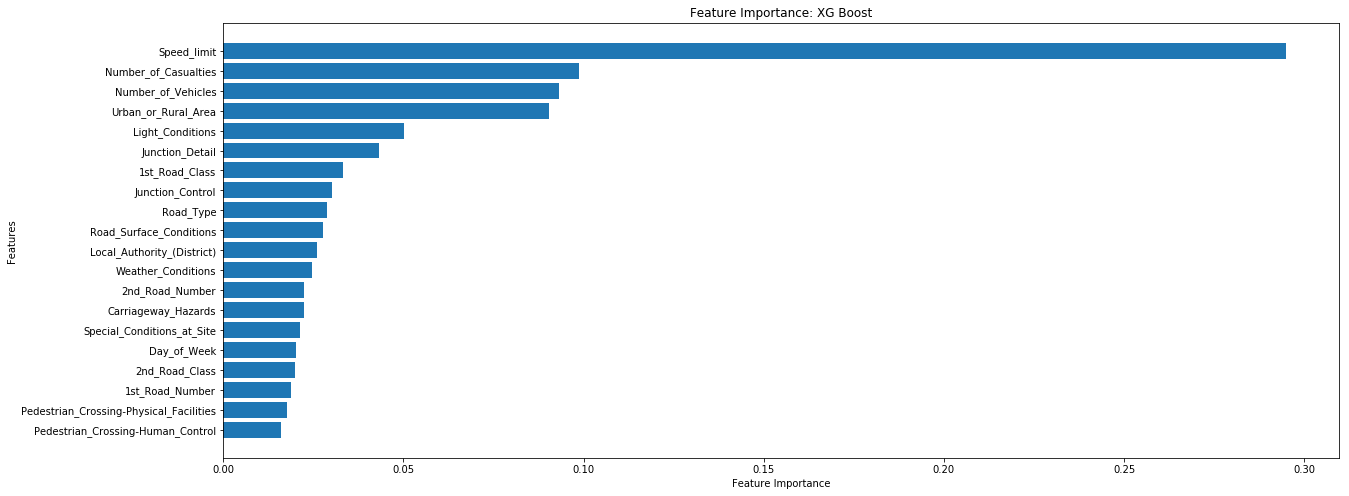

In [669]:
#To create the list of Importance used for the Importance plot
imp = np.array(scale_xgbopti_pipeline.steps[1][1].feature_importances_).reshape(-1,1)

impor = [None] * len(imp)

for i,v in enumerate(imp):
    impor[i] = imp[i][0]
    
#Plotting the feature importacne from the basic LGR model
plt.subplots(figsize=(20,8))
plt.rcParams.update({'font.size': 10})

names = features.columns

impor2, names = zip(*sorted(zip(impor, names)))

plt.barh(range(len(names)),impor2, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance: XG Boost')
plt.show()

### Appendix: Precision vs Recall deep dive

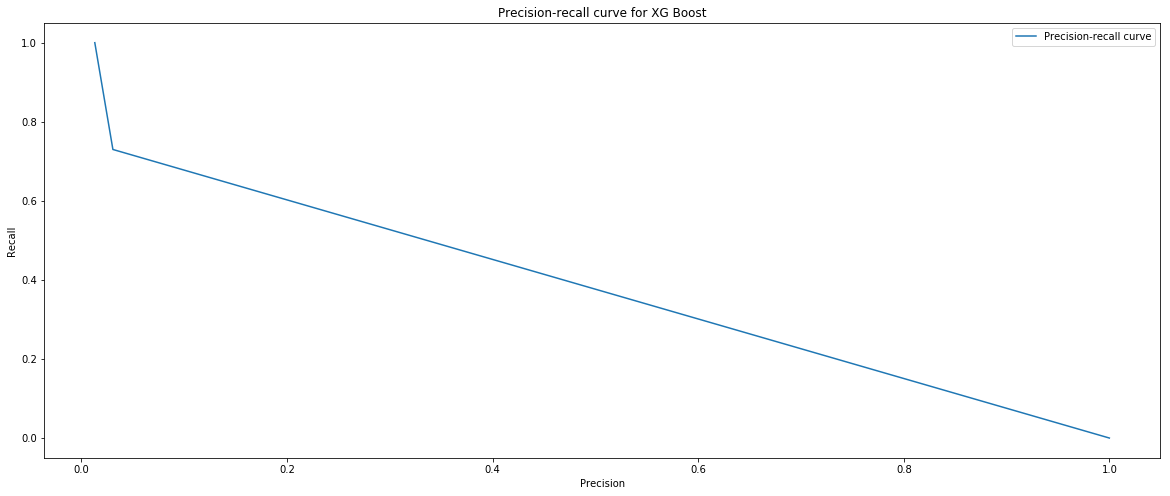

In [673]:
#Return precision and recall from xg boost model
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_new)
# create plot

plt.subplots(figsize=(20,8))
plt.plot(precision, recall, label = 'Precision-recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve for XG Boost')
plt.legend(loc = "upper right")

In [672]:

#With the precision-recall curve, the closer it is to the top-right corner, the better the algorithm. 
#And hence a larger area under the curve (AUC) indicates that the algorithm has higher recall and higher precision. 

average_precision_score(y_test, pos_proba_xgbopti)

0.05598244394032902